## Obtaining Twitter data

In [1]:
# Load libraries
import pandas as pd
import time
import json

# Load Twitter API client
from searchtweets import ResultStream, gen_rule_payload, load_credentials, collect_results

### Define API arguments

In [2]:
# Define arguments to be able to connect to Twitter API for the last 30 days of tweets
premium_30day_search_args = load_credentials(filename=".twitter_keys.yaml",
                 yaml_key="search_30day_tweets_api",
                 env_overwrite=False)

# Define arguments to be able to connect to Twitter API for the last 30 days of tweets
premium_fullarchive_search_args = load_credentials(filename=".twitter_keys.yaml",
                 yaml_key="search_fullarchive_tweets_api",
                 env_overwrite=False)


Grabbing bearer token from OAUTH
Grabbing bearer token from OAUTH


### Extract last 30 days data

In [3]:
# Extract last 30 days tweets using Twitter API
# This is due to tweets older than 30 days use a different end point and limit quota

write_to_disk = False
if write_to_disk:
    all_tweets = []
    for t in list(range(1,30)):
        from_date = str(t).zfill(2)
        to_date = str(t+1).zfill(2)

        rule = gen_rule_payload(
            "UK coronavirus lang:en",
            from_date=f"2020-05-{from_date}", 
            to_date=f"2020-05-{to_date}",
            results_per_call=100
        )

        tweets = collect_results(rule, max_results=500, result_stream_args=premium_30day_search_args) 

        all_tweets.extend(tweets)
        print(len(all_tweets))
        # Set a sleep time to avoid hitting API limits
        time.sleep(10)

        # Write extacted tweets to a JSON file
        with open('data/tweets/data.json', 'w', encoding='utf-8') as f:
            json.dump(all_tweets, f, indent=4, ensure_ascii=False)
        
        

### Extract data older than 30 days

In [4]:
# Extract tweets older than 30 days
# This is due to tweets older than 30 days use a different end point and limit quota

# Extract tweets older then 30 days using Twitter API
write_to_disk = False
if write_to_disk:
    month = '04' # specify month number
#     all_tweets = []
    for t in list(range(1,30)):
        from_date = str(t).zfill(2)
        to_date = str(t+1).zfill(2)

        rule = gen_rule_payload(
            "UK coronavirus lang:en",
            from_date=f"2020-{month}-{from_date}", 
            to_date=f"2020-{month}-{to_date}",
            results_per_call=100
        )

        tweets = collect_results(rule, max_results=150, result_stream_args=premium_fullarchive_search_args) 

        all_tweets.extend(tweets)
        print(f"2020-{month}-{to_date}")
        print(len(all_tweets))
        print('---')
        # Set a sleep time to avoid hitting API limits
        time.sleep(10)

        # Write extacted tweets to a JSON file
        with open('data/tweets/data.json', 'w', encoding='utf-8') as f:
            json.dump(all_tweets, f, indent=4, ensure_ascii=False)

### Load tweet data

In [5]:
# Read JSON file that contains tweet data
with open('data/tweets/data.json', 'r',) as f:
    tweets = json.load(f)

# Check number of tweets
len(tweets)

22250

In [6]:
# Print twitter text sample
[print(tweet.get('text'),'\n\n') for tweet in tweets[0:3]]

RT @reactionlife: Why is Germany able to test for coronavirus so much more than the UK? - @reactionlife https://t.co/9xltrMYhNu 


RT @cdhawesi: 'Absolutely wrong': how UK's coronavirus test strategy unravelled | Coronavirus outbreak | The Guardian https://t.co/gJK3mppm… 


RT @Independent: US Coast Guard orders foreign cruise ships to care for suspected coronavirus passengers on board 'indefinitely' https://t.… 




[None, None, None]

In [7]:
# Check all keys associated with individual tweet objects
tweet_keys = []
for t in tweets:
    tweet_keys.extend(list(t.keys()))
    tweet_keys = list(set(tweet_keys))
    
tweet_keys = sorted(tweet_keys)
tweet_keys

['contributors',
 'coordinates',
 'created_at',
 'display_text_range',
 'entities',
 'extended_entities',
 'extended_tweet',
 'favorite_count',
 'favorited',
 'filter_level',
 'geo',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'matching_rules',
 'place',
 'possibly_sensitive',
 'quote_count',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'quoted_status_permalink',
 'reply_count',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'source',
 'text',
 'truncated',
 'user']

In [8]:
# Check whether all tweets are unique tweets
unique_tweets = []
ids = []
for t in tweets:
    if not t.get('id') in ids:
        ids.append(t.get('id'))
        unique_tweets.append(t)
    else:
        pass

len(unique_tweets)

22250

In [9]:
# Extract text content from individual tweets
write_text_tweets = False

import json

# Read JSON file that contains tweet data
with open('data/tweets/data.json', 'r',) as f:
    tweets = json.load(f)
    
# Check whether all tweets are unique tweets
unique_tweets = []
ids = []
for t in tweets:
    if not t.get('id') in ids:
        ids.append(t.get('id'))
        unique_tweets.append(t)
    else:
        pass

len(unique_tweets)

# Check number of tweets
print(len(tweets))

# Extract text content from individual tweets

if write_text_tweets:
    
    text_tweets = []
    for t in unique_tweets:
        
        t_ = {}
        t_['id'] = t.get('id')
        t_['created_at'] = t.get('created_at')
        if t.get('extended_tweet'):
            t_['text'] = t.get('extended_tweet').get('full_text')
        else:
            t_['text'] = t.get('text')
            
        text_tweets.append(t_)
            
        t_r = {}
        if t.get('retweeted_status'):
            t_r['id'] = t.get('retweeted_status').get('id')
            t_r['created_at'] = t.get('retweeted_status').get('created_at')
            if t.get('retweeted_status').get('extended_tweet'):
                t_r['text'] = t.get('retweeted_status').get('extended_tweet').get('full_text')
            else:
                t_r['text'] = t.get('retweeted_status').get('text')
              
            text_tweets.append(t_r)
            
        else:
            pass



    print(len(text_tweets))

    df = pd.DataFrame(text_tweets)
    df.to_csv('data/tweets/tweets_extended.csv', encoding='utf-8', index=False)
    print('Tweet text saved to file!')
            

22250


In [10]:
df = pd.read_csv('data/tweets/tweets_extended.csv', encoding='utf-8',)
len(df)

39873

## Scrubbing the text

In [11]:
def remove_emojis(text):
    import re
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', text)

In [12]:
# Define text processing function
def preprocess(text):
    import re, string
    
    text = text.replace('(<br/>)', ' ')
    text = text.replace('(&amp)', ' ')
    text = text.replace('(&gt)', ' ')
    text = text.replace('(&lt)', ' ')
    text = text.replace('(\xa0)', ' ')
    text = text.replace(r'\n',' ',)
    text = text.replace('"',' ',)
    text = text.replace("'",' ',)
    
    # Remove URL
    text = re.sub(r"(?:\@|http?\://|https?\://|www.)\S+", "", text)
    
    # Remove emoji
    text = remove_emojis(text)
    
    # Remove punctuation
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
    
    # Remove white space
    text = " ".join(text.split())
    
    return text

In [13]:
df['cleaned_text'] = df['text'].apply(preprocess)


In [14]:
df.head()


,id,created_at,text,cleaned_text
0,1245501194375700483,Wed Apr 01 23:59:59 +0000 2020,RT @reactionlife: Why is Germany able to test ...,RT Why is Germany able to test for coronavirus...
1,1245075899558625280,Tue Mar 31 19:50:01 +0000 2020,Why is Germany able to test for coronavirus so...,Why is Germany able to test for coronavirus so...
2,1245501189208276996,Wed Apr 01 23:59:58 +0000 2020,RT @cdhawesi: 'Absolutely wrong': how UK's cor...,RT Absolutely wrong how UK s coronavirus test ...
3,1245498501011775489,Wed Apr 01 23:49:17 +0000 2020,'Absolutely wrong': how UK's coronavirus test ...,Absolutely wrong how UK s coronavirus test str...
4,1245501189136867328,Wed Apr 01 23:59:58 +0000 2020,RT @Independent: US Coast Guard orders foreign...,RT US Coast Guard orders foreign cruise ships ...


In [15]:
# Saving tweet data as csv
df.to_csv('data/tweets/cleaned_tweets.csv', encoding='utf-8', index=False)


## Exploratory Data Analysis  

### VADER Sentiment Analysis and Feature Engineering

In [16]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Creating columns for each polarity score
df['negative'] = df['cleaned_text'].apply(lambda cleaned_text: analyzer.polarity_scores(cleaned_text)['neg'])
df['neutral'] = df['cleaned_text'].apply(lambda cleaned_text: analyzer.polarity_scores(cleaned_text)['neu'])
df['positive'] = df['cleaned_text'].apply(lambda cleaned_text: analyzer.polarity_scores(cleaned_text)['pos'])
df['compound'] = df['cleaned_text'].apply(lambda cleaned_text: analyzer.polarity_scores(cleaned_text)['compound'])


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39873 entries, 0 to 39872
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            39873 non-null  int64  
 1   created_at    39873 non-null  object 
 2   text          39873 non-null  object 
 3   cleaned_text  39873 non-null  object 
 4   negative      39873 non-null  float64
 5   neutral       39873 non-null  float64
 6   positive      39873 non-null  float64
 7   compound      39873 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 2.4+ MB


It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

positive sentiment: compound score >= 0.05

neutral sentiment: (compound score > -0.05) and (compound score < 0.05)

negative sentiment: compound score <= -0.05

In [18]:
df['vader_score'] = df['compound'].apply(lambda x: -1 if x<= -0.06 else(1 if x>= 0.06 else 0))

In [19]:
df['text_len'] = df['cleaned_text'].astype(str).apply(len)
df['text_word_count'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))

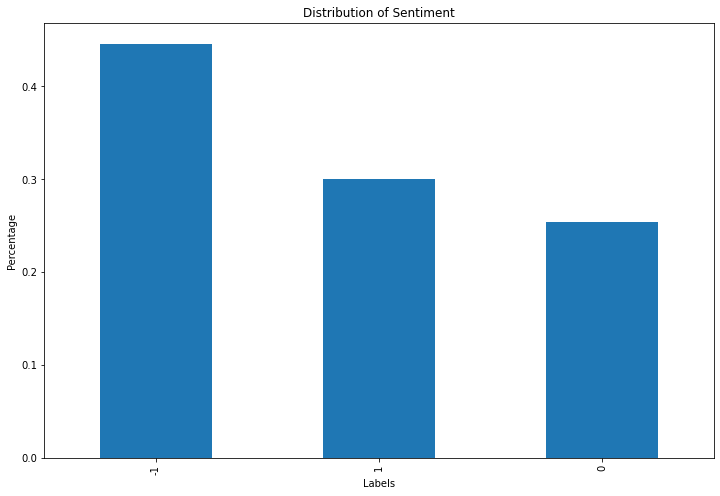

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(12,8))
df['vader_score'].value_counts(normalize=True).plot.bar()
ax.set_ylabel('Percentage')
ax.set_xlabel('Labels')
ax.set_title('Distribution of Sentiment')
plt.show()

### Visualizing  Sentiment Scores

In [21]:
# Converting the columns type to datetime
df['date'] = pd.to_datetime(df['created_at'], errors='coerce')
df.head()


,id,created_at,text,cleaned_text,negative,neutral,positive,compound,vader_score,text_len,text_word_count,date
0,1245501194375700483,Wed Apr 01 23:59:59 +0000 2020,RT @reactionlife: Why is Germany able to test ...,RT Why is Germany able to test for coronavirus...,0.000,1.000,0.000,0.0000,0,71,15,2020-04-01 23:59:59+00:00
1,1245075899558625280,Tue Mar 31 19:50:01 +0000 2020,Why is Germany able to test for coronavirus so...,Why is Germany able to test for coronavirus so...,0.000,1.000,0.000,0.0000,0,68,14,2020-03-31 19:50:01+00:00
2,1245501189208276996,Wed Apr 01 23:59:58 +0000 2020,RT @cdhawesi: 'Absolutely wrong': how UK's cor...,RT Absolutely wrong how UK s coronavirus test ...,0.207,0.793,0.000,-0.5256,-1,99,14,2020-04-01 23:59:58+00:00
3,1245498501011775489,Wed Apr 01 23:49:17 +0000 2020,'Absolutely wrong': how UK's coronavirus test ...,Absolutely wrong how UK s coronavirus test str...,0.220,0.780,0.000,-0.5256,-1,96,13,2020-04-01 23:49:17+00:00
4,1245501189136867328,Wed Apr 01 23:59:58 +0000 2020,RT @Independent: US Coast Guard orders foreign...,RT US Coast Guard orders foreign cruise ships ...,0.095,0.746,0.159,0.3182,1,112,17,2020-04-01 23:59:58+00:00


In [22]:
# Defining a new dataframe and setting date as index
df_a = df[['date', 'negative', 'neutral', 'positive', 'compound']].set_index('date')
df_a.head()

,negative,neutral,positive,compound
date,,,,
2020-04-01 23:59:59+00:00,0.000,1.000,0.000,0.0000
2020-03-31 19:50:01+00:00,0.000,1.000,0.000,0.0000
2020-04-01 23:59:58+00:00,0.207,0.793,0.000,-0.5256
2020-04-01 23:49:17+00:00,0.220,0.780,0.000,-0.5256
2020-04-01 23:59:58+00:00,0.095,0.746,0.159,0.3182


In [23]:
# Limiting index with the related tweet data
df_ = df_a['2020-03-15':'2020-05-30']
df_.index.min()

Timestamp('2020-03-15 06:29:50+0000', tz='UTC')

In [24]:
# Calculating daily average for each column
av_daily = df_.resample('D').mean()
av_daily.head(10)


,negative,neutral,positive,compound
date,,,,
2020-03-15 00:00:00+00:00,0.034333,0.927000,0.038667,0.082750
2020-03-16 00:00:00+00:00,0.082466,0.874495,0.043042,-0.123427
2020-03-17 00:00:00+00:00,0.089861,0.822636,0.087528,-0.025213
2020-03-18 00:00:00+00:00,0.084175,0.854461,0.061358,-0.061395
2020-03-19 00:00:00+00:00,0.060422,0.867059,0.072541,0.045386
2020-03-20 00:00:00+00:00,0.093592,0.832573,0.073805,-0.081103
2020-03-21 00:00:00+00:00,0.107958,0.812903,0.079232,-0.135561
2020-03-22 00:00:00+00:00,0.083513,0.848090,0.068423,-0.046503
2020-03-23 00:00:00+00:00,0.091123,0.831240,0.077645,-0.052944


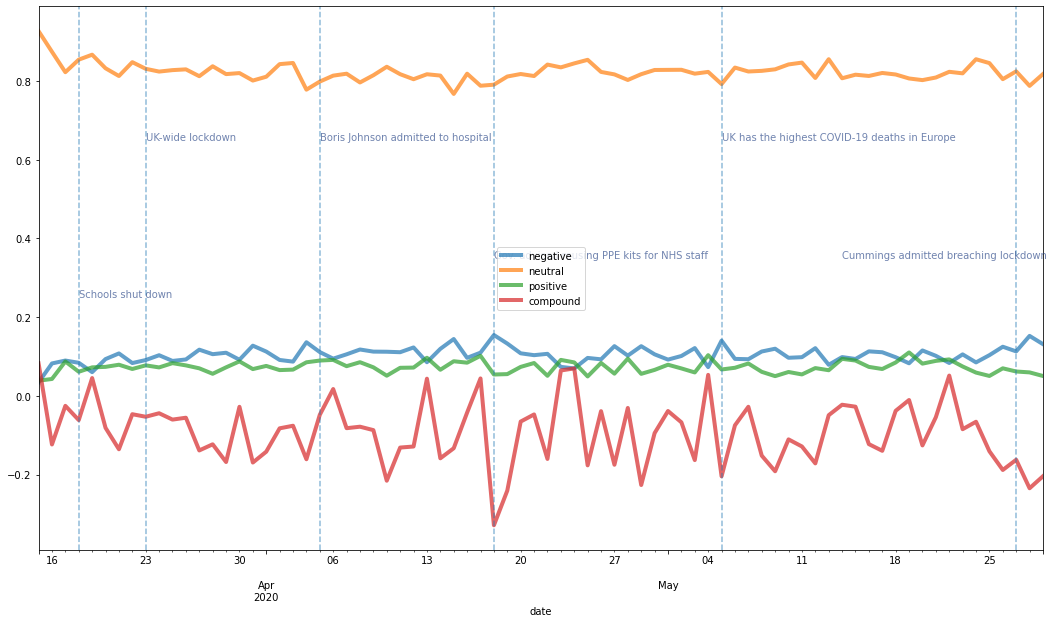

In [25]:
# Visualizing polarity scores
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

fig, ax = plt.subplots(figsize=(18, 10))
style = dict(size=9, color='black')

av_daily.plot(ax=ax, lw=4, alpha=0.7, subplots=False, legend=True)

x_line_annotation = datetime(2020, 3, 18) 
x_text_annotation = datetime(2020, 3, 18) 
ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
ax.text(x=x_text_annotation, y=0.25, s='Schools shut down', alpha=0.7, color='#334f8d')

x_line_annotation = datetime(2020, 4, 5) 
x_text_annotation = datetime(2020, 4, 5) 
ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
ax.text(x=x_text_annotation, y=0.65, s='Boris Johnson admitted to hospital', alpha=0.7, color='#334f8d')

x_line_annotation = datetime(2020, 3, 23) 
x_text_annotation = datetime(2020, 3, 23) 
ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
ax.text(x=x_text_annotation, y=0.65, s='UK-wide lockdown', alpha=0.7, color='#334f8d')


x_line_annotation = datetime(2020, 4, 18) 
x_text_annotation = datetime(2020, 4, 18) 
ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
ax.text(x=x_text_annotation, y=0.35, s='Gov. adviced reusing PPE kits for NHS staff', alpha=0.7, color='#334f8d')


x_line_annotation = datetime(2020, 5, 5) 
x_text_annotation = datetime(2020, 5, 5) 
ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
ax.text(x=x_text_annotation, y=0.65, s='UK has the highest COVID-19 deaths in Europe', alpha=0.7, color='#334f8d')

x_line_annotation = datetime(2020, 5, 27) 
x_text_annotation = datetime(2020, 5, 14) 
ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
ax.text(x=x_text_annotation, y=0.35, s='Cummings admitted breaching lockdown', alpha=0.7, color='#334f8d')

plt.show()


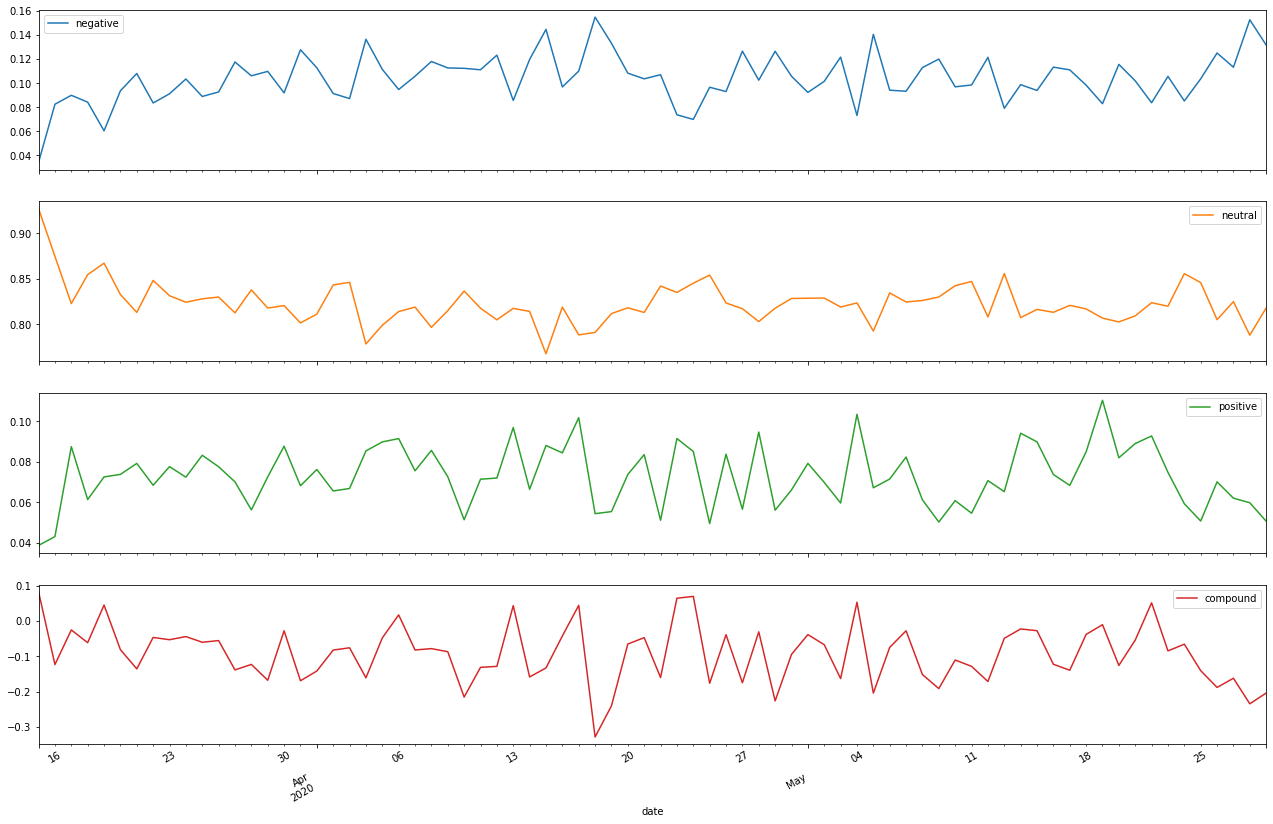

In [26]:
# Plot the yearly groups as subplots
av_daily.plot(figsize = (22,15), subplots=True, legend=True)
plt.show()


### Ngram Exploration


#### Unigrams 

In [27]:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
np.random.seed(0)


In [28]:
# 
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


In [29]:
# Getting top 50 unigrams
unigrams = get_top_n_words(df['cleaned_text'],50)


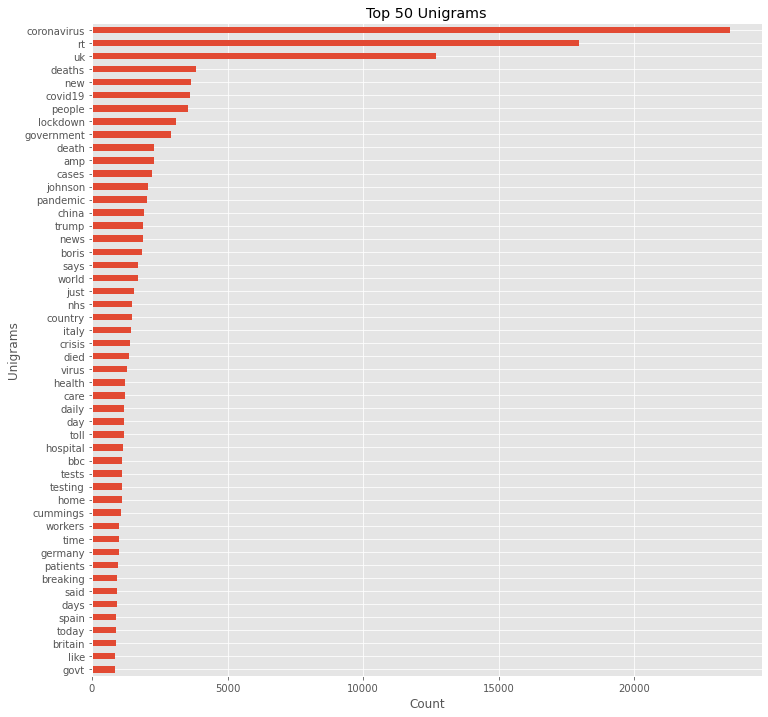

In [30]:
# Visualizing top 50 unigrams
df_uni = pd.DataFrame(unigrams, columns = ['text' , 'count'])

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12,12))
df_uni.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax);
ax.set_xlabel('Count')
ax.set_ylabel('Unigrams')
ax.set_title('Top 50 Unigrams')
plt.show()


In [31]:
pos = df[df['vader_score']== 1]
neg = df[df['vader_score']== -1]
neutral = df[df['vader_score']== 0]

In [32]:
pos_unigrams = get_top_n_words(pos['cleaned_text'],20)
neg_unigrams = get_top_n_words(neg['cleaned_text'],20)
neutral_unigrams = get_top_n_words(neutral['cleaned_text'],20)

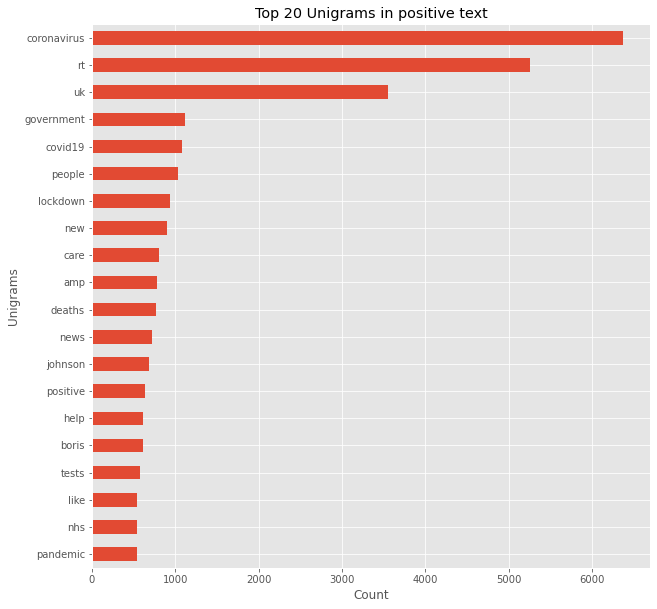

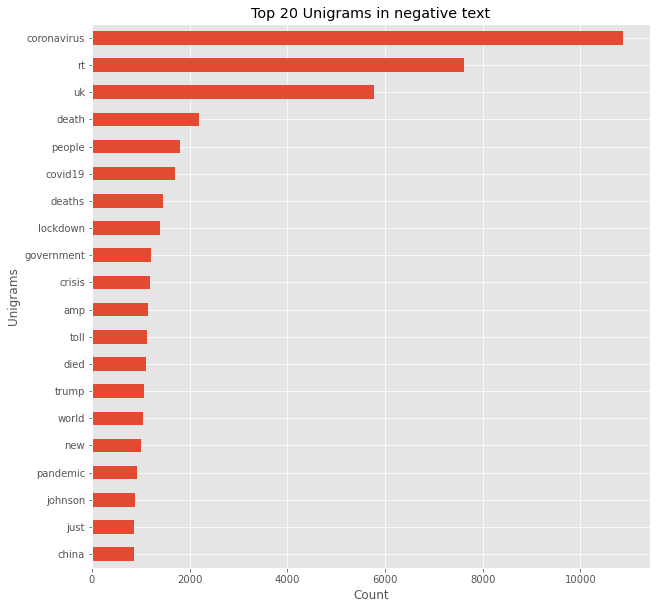

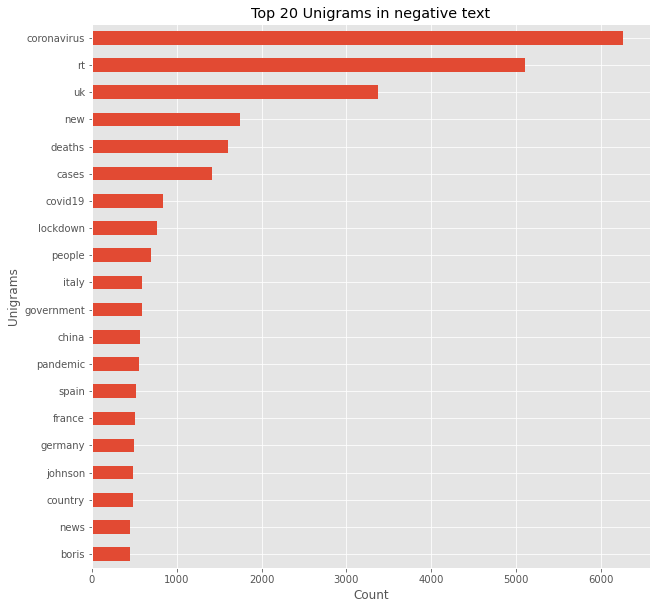

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
df1 = pd.DataFrame(pos_unigrams, columns = ['text' , 'count'])
df1.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax)
ax.set_xlabel('Count')
ax.set_ylabel('Unigrams')
ax.set_title('Top 20 Unigrams in positive text')
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
df2 = pd.DataFrame(neg_unigrams, columns = ['text' , 'count'])
df2.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax)
ax.set_xlabel('Count')
ax.set_ylabel('Unigrams')
ax.set_title('Top 20 Unigrams in negative text')
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
df3 = pd.DataFrame(neutral_unigrams, columns = ['text' , 'count'])
df3.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax)
ax.set_xlabel('Count')
ax.set_ylabel('Unigrams')
ax.set_title('Top 20 Unigrams in negative text')
plt.show()

#### Bigrams 

In [34]:
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [35]:
bigrams = get_top_n_gram(df['cleaned_text'],(2,2),50)

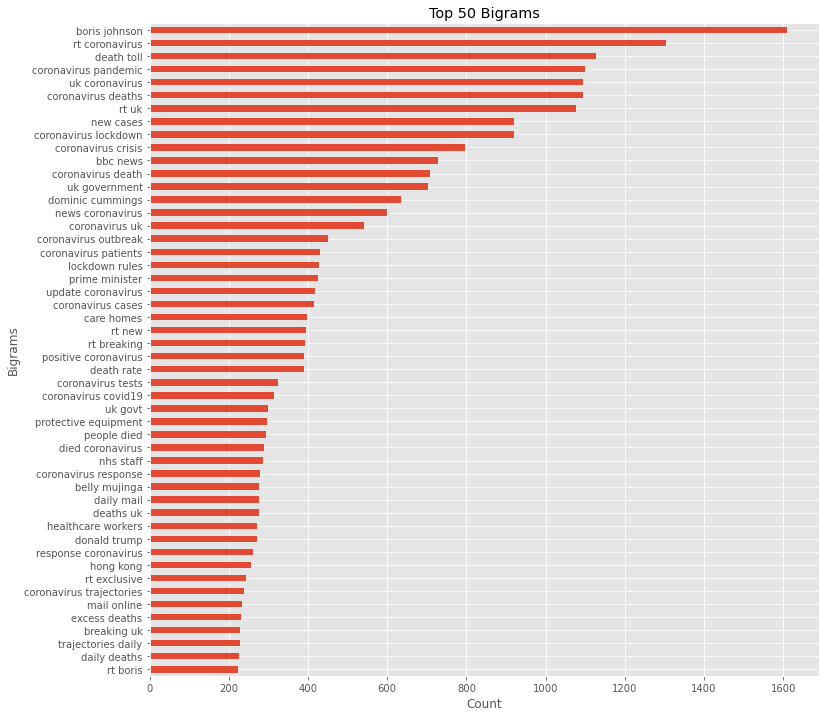

In [36]:
fig, ax = plt.subplots(figsize=(12,12))
df_bigram = pd.DataFrame(bigrams, columns = ['text' , 'count'])
df_bigram.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax);
ax.set_xlabel('Count')
ax.set_ylabel('Bigrams')
ax.set_title('Top 50 Bigrams')
plt.show()

In [37]:
pos_bigrams = get_top_n_gram(pos['cleaned_text'],(2,2),20)
neg_bigrams = get_top_n_gram(neg['cleaned_text'],(2,2),20)
neutral_bigrams = get_top_n_gram(neutral['cleaned_text'],(2,2),20)


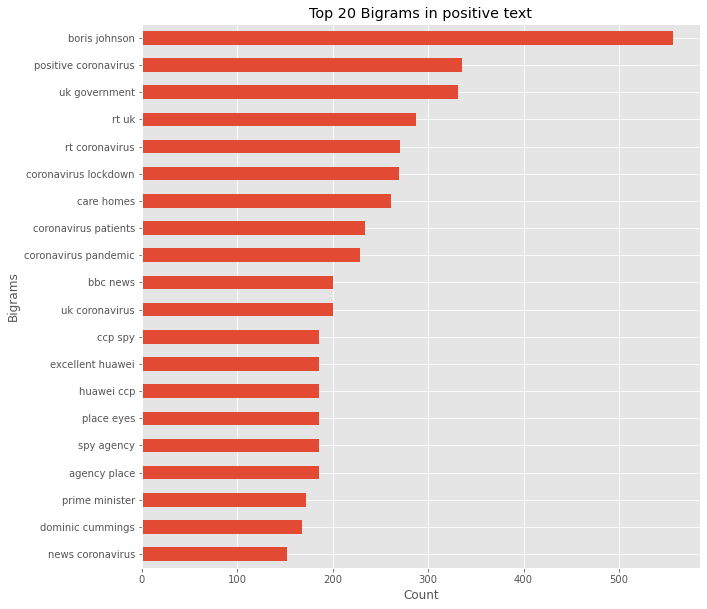

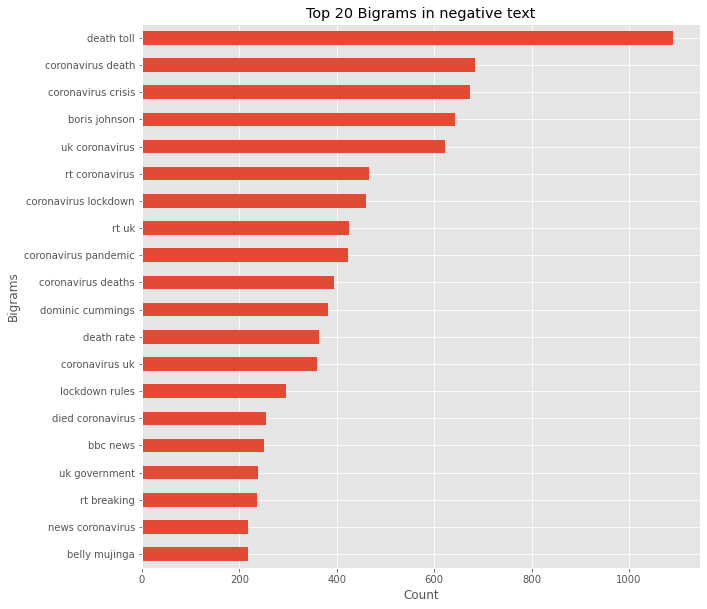

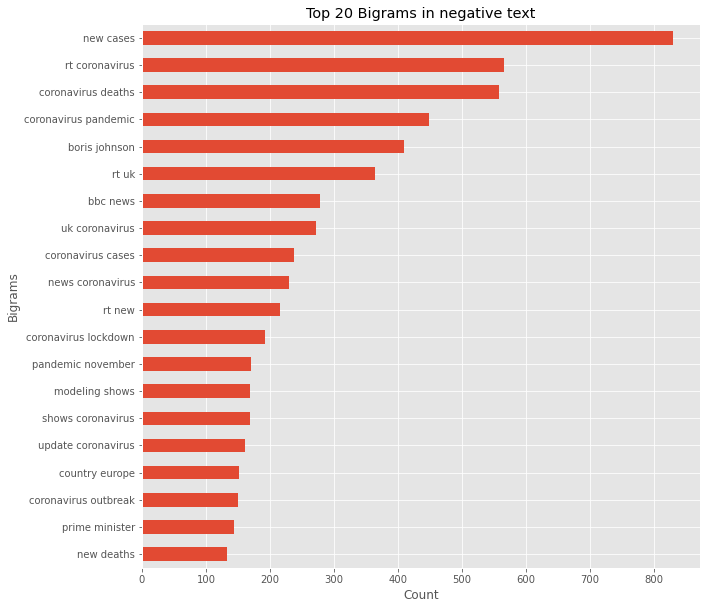

In [38]:
fig, ax = plt.subplots(figsize=(10,10))
df1 = pd.DataFrame(pos_bigrams, columns = ['text' , 'count'])
df1.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax)
ax.set_xlabel('Count')
ax.set_ylabel('Bigrams')
ax.set_title('Top 20 Bigrams in positive text')
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
df2 = pd.DataFrame(neg_bigrams, columns = ['text' , 'count'])
df2.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax)
ax.set_xlabel('Count')
ax.set_ylabel('Bigrams')
ax.set_title('Top 20 Bigrams in negative text')
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
df3 = pd.DataFrame(neutral_bigrams, columns = ['text' , 'count'])
df3.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax)
ax.set_xlabel('Count')
ax.set_ylabel('Bigrams')
ax.set_title('Top 20 Bigrams in negative text')
plt.show()

####  Trigrams

In [39]:
trigrams = get_top_n_gram(df['cleaned_text'],(3,3),20)

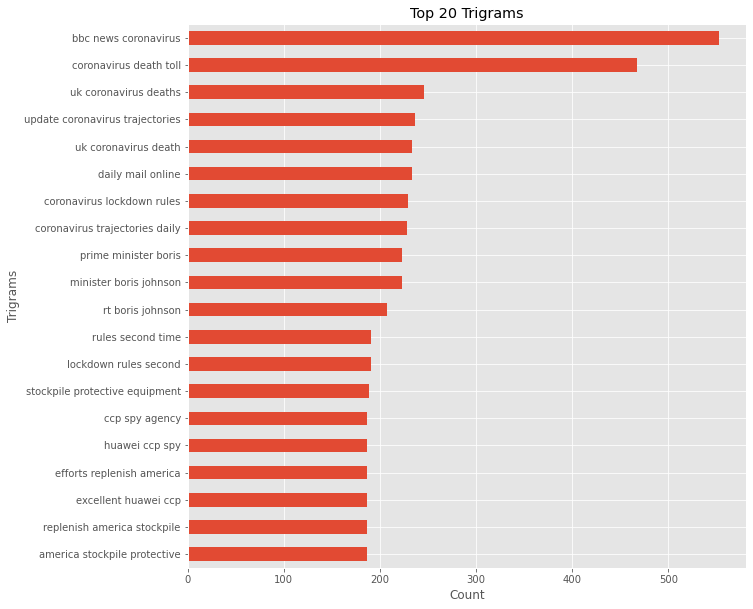

In [40]:
df_trigrams = pd.DataFrame(trigrams, columns = ['text' , 'count'])

fig, ax = plt.subplots(figsize=(10,10))
df_trigrams.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax);
ax.set_xlabel('Count')
ax.set_ylabel('Trigrams')
ax.set_title('Top 20 Trigrams')
plt.show()

In [41]:
pos_trigrams = get_top_n_gram(pos['cleaned_text'],(3,3),20)
neg_trigrams = get_top_n_gram(neg['cleaned_text'],(3,3),20)
neutral_trigrams = get_top_n_gram(neutral['cleaned_text'],(3,3),20)

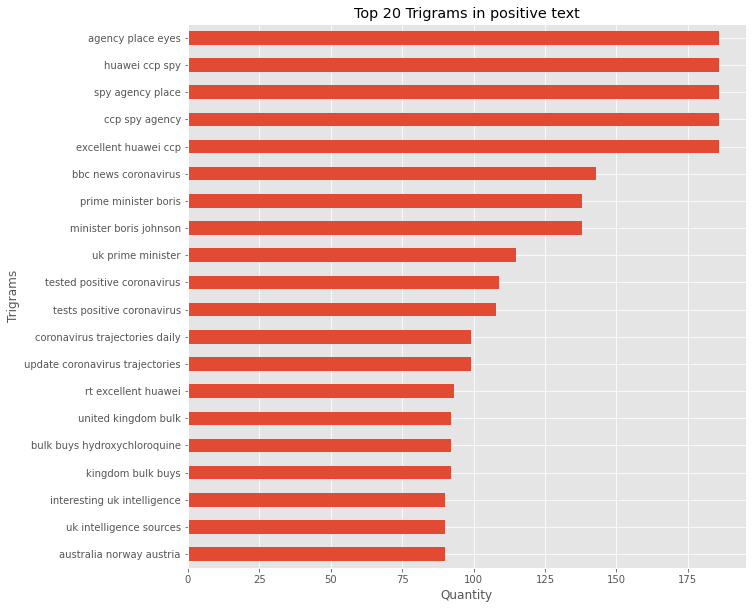

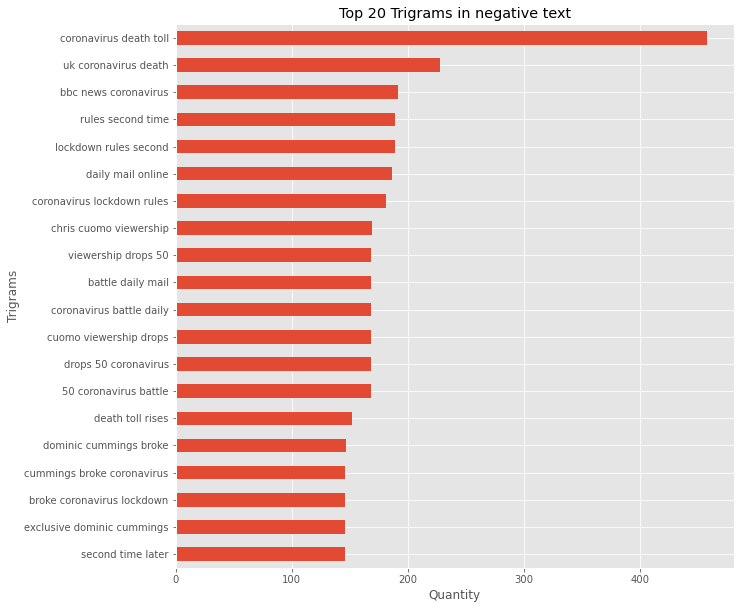

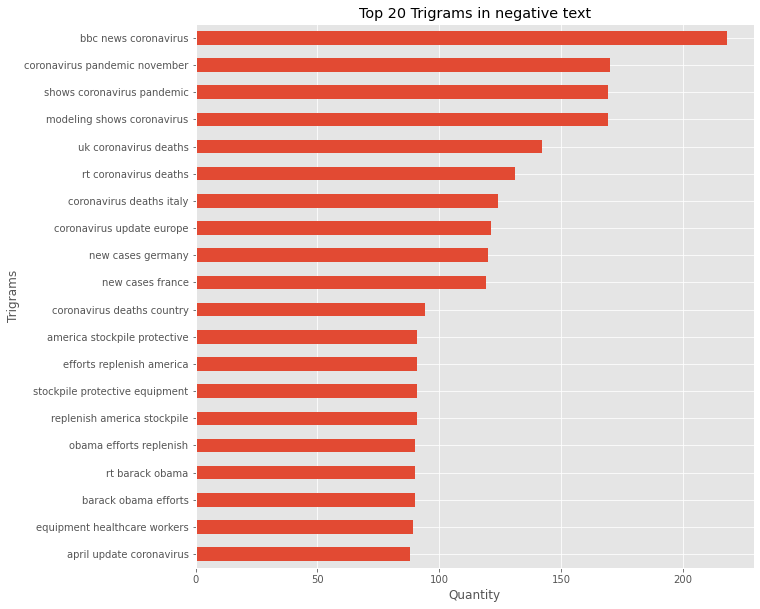

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
df1 = pd.DataFrame(pos_trigrams, columns = ['text' , 'count'])
df1.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax)
ax.set_xlabel('Quantity')
ax.set_ylabel('Trigrams')
ax.set_title('Top 20 Trigrams in positive text')
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
df2 = pd.DataFrame(neg_trigrams, columns = ['text' , 'count'])
df2.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax)
ax.set_xlabel('Quantity')
ax.set_ylabel('Trigrams')
ax.set_title('Top 20 Trigrams in negative text')
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
df3 = pd.DataFrame(neutral_trigrams, columns = ['text' , 'count'])
df3.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax)
ax.set_xlabel('Quantity')
ax.set_ylabel('Trigrams')
ax.set_title('Top 20 Trigrams in negative text')
plt.show()

### Text Statistics

#### Text word count analysis

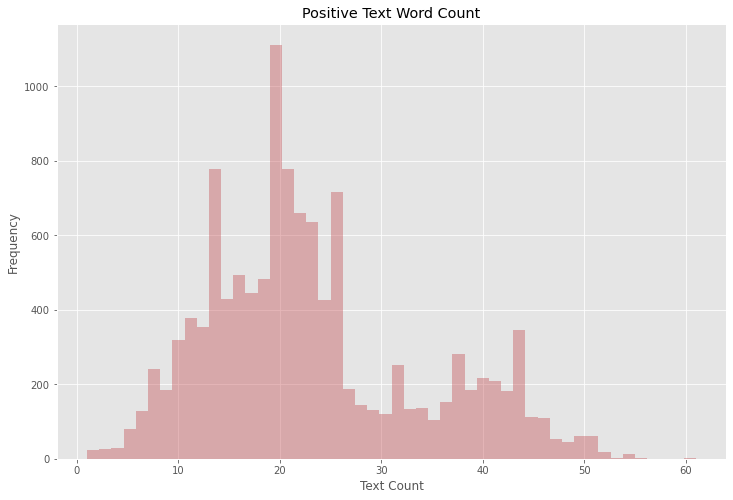

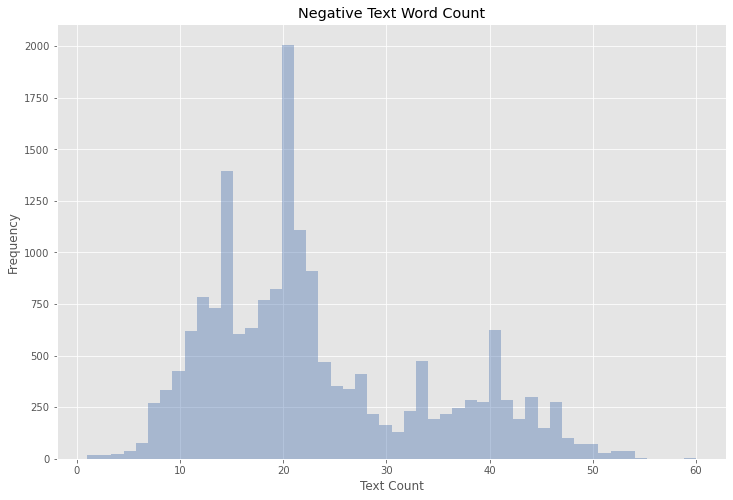

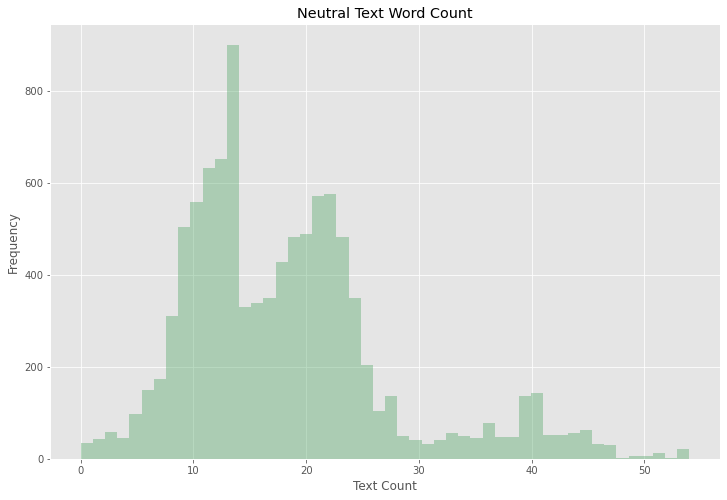

In [43]:
import seaborn as sns

plt.figure(figsize=(12,8))
sns.set_color_codes()
ax = sns.distplot(pos['text_word_count'], color="r", kde=False)
ax.set(title = 'Positive Text Word Count', xlabel = 'Text Count', ylabel = 'Frequency');

plt.figure(figsize=(12,8))
ax = sns.distplot(neg['text_word_count'], color="b", kde=False)
ax.set(title = 'Negative Text Word Count', xlabel = 'Text Count', ylabel = 'Frequency');

plt.figure(figsize=(12,8))
ax = sns.distplot(neutral['text_word_count'], color="g", kde=False)
ax.set(title = 'Neutral Text Word Count', xlabel = 'Text Count', ylabel = 'Frequency');

#### Sentence length analysis

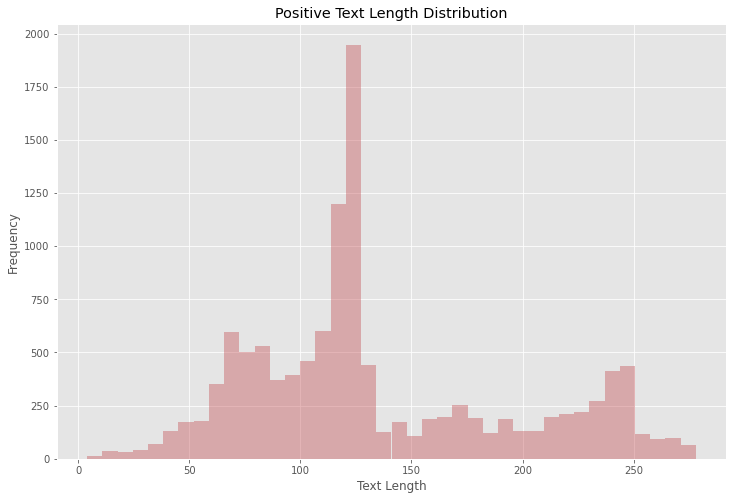

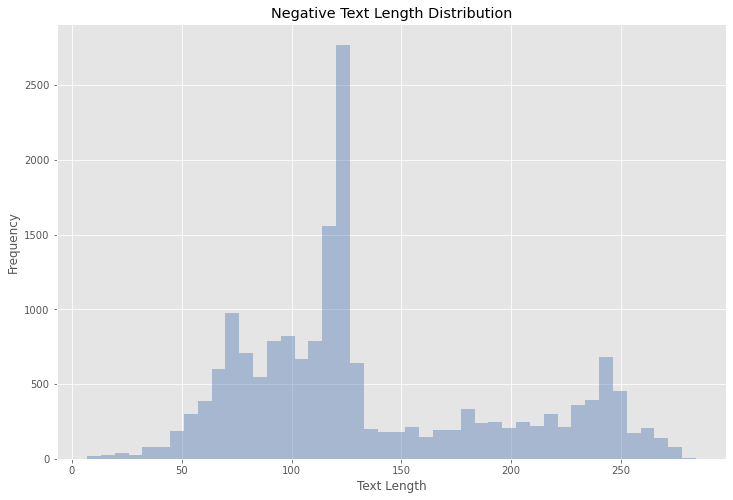

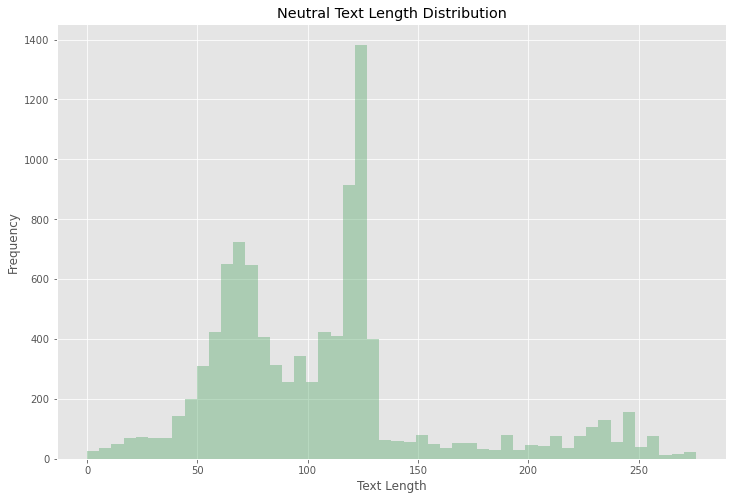

In [44]:
import seaborn as sns

plt.figure(figsize=(12,8))
sns.set_color_codes()
ax = sns.distplot(pos['text_len'], color="r", kde=False)
ax.set(title = 'Positive Text Length Distribution', xlabel = 'Text Length', ylabel = 'Frequency');

plt.figure(figsize=(12,8))
ax = sns.distplot(neg['text_len'], color="b", kde=False)
ax.set(title = 'Negative Text Length Distribution', xlabel = 'Text Length', ylabel = 'Frequency');

plt.figure(figsize=(12,8))
ax = sns.distplot(neutral['text_len'], color="g", kde=False)
ax.set(title = 'Neutral Text Length Distribution', xlabel = 'Text Length', ylabel = 'Frequency');


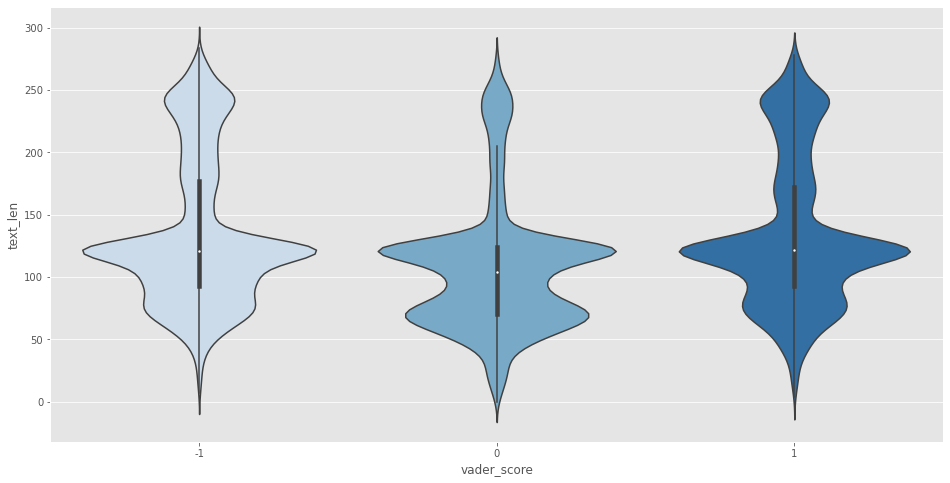

In [45]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.violinplot(x="vader_score", y='text_len', palette="Blues", data=df);

### WordClouds 

In [46]:
positive_text = df[df['vader_score'] == 1]['cleaned_text']
negative_text = df[df['vader_score'] == -1]['cleaned_text']
neutral_text = df[df['vader_score'] == 0]['cleaned_text']

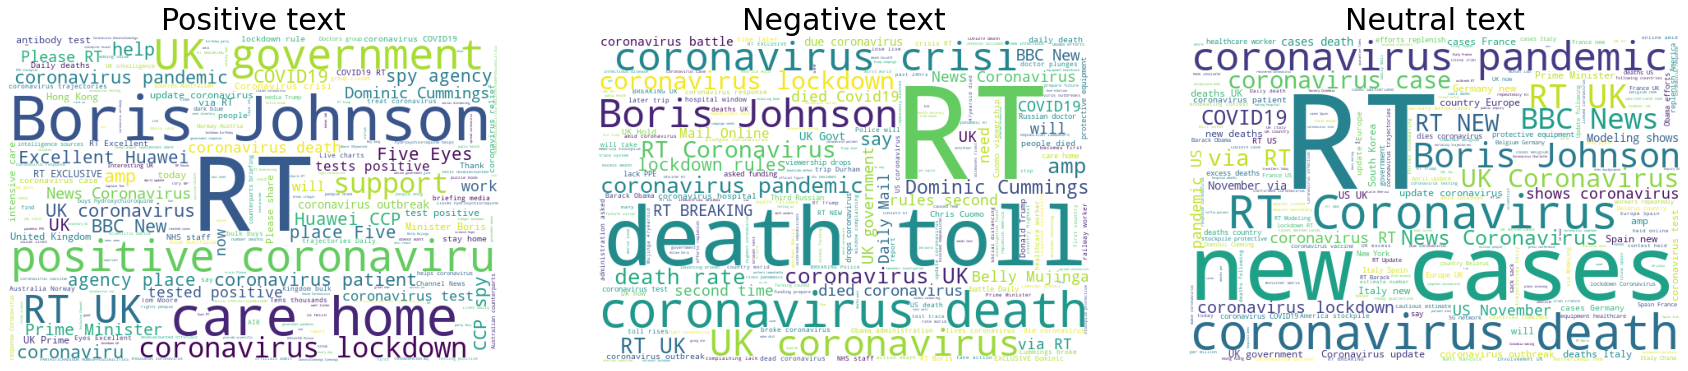

In [47]:
from wordcloud import WordCloud
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive_text))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive text',fontsize=30);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative_text))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative text',fontsize=30);

wordcloud3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(neutral_text))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutral text',fontsize=30);

## Modeling

### Time  Series with ARIMA

#### Data Preparation

In [48]:
import pandas as pd
df_deaths = pd.read_csv('coronavirus_deaths_latest.csv')
df_deaths.head(10)


,Area name,Area code,Area type,Reporting date,Daily change in deaths,Cumulative deaths
0,Wales,W92000004,Nation,2020-06-09,9.0,1410
1,Scotland,S92000003,Nation,2020-06-09,0.0,2415
2,Northern Ireland,N92000002,Nation,2020-06-09,0.0,537
3,United Kingdom,K02000001,UK,2020-06-09,286.0,40883
4,England,E92000001,Nation,2020-06-09,277.0,36521
5,Wales,W92000004,Nation,2020-06-08,3.0,1401
6,Scotland,S92000003,Nation,2020-06-08,0.0,2415
7,Northern Ireland,N92000002,Nation,2020-06-08,0.0,537
8,United Kingdom,K02000001,UK,2020-06-08,55.0,40597
9,England,E92000001,Nation,2020-06-08,52.0,36244


In [49]:
df_deaths.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Area name               446 non-null    object 
 1   Area code               446 non-null    object 
 2   Area type               446 non-null    object 
 3   Reporting date          446 non-null    object 
 4   Daily change in deaths  442 non-null    float64
 5   Cumulative deaths       446 non-null    int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 21.0+ KB


In [50]:
df_deaths['date'] = pd.to_datetime(df_deaths['Reporting date'], errors='coerce')


In [51]:
df_deaths['date'].dtype


dtype('<M8[ns]')

In [52]:
df_deaths.sort_values(by=['date'], inplace=True, ascending=True)


In [53]:
df_deaths.head()


,Area name,Area code,Area type,Reporting date,Daily change in deaths,Cumulative deaths,date
445,England,E92000001,Nation,2020-03-06,NaN,1,2020-03-06
444,United Kingdom,K02000001,UK,2020-03-06,1.0,1,2020-03-06
442,United Kingdom,K02000001,UK,2020-03-07,1.0,2,2020-03-07
443,England,E92000001,Nation,2020-03-07,1.0,2,2020-03-07
440,United Kingdom,K02000001,UK,2020-03-08,0.0,2,2020-03-08


In [54]:
df_d= df_deaths[['date', 'Area name', 'Daily change in deaths']].set_index('date')


In [55]:
series= df_d.loc[df_d['Area name']=='United Kingdom']


In [56]:
series.drop(['Area name'], axis=1, inplace=True)


/Users/esra/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [57]:
series.head()


,Daily change in deaths
date,
2020-03-06,1.0
2020-03-07,1.0
2020-03-08,0.0
2020-03-09,1.0
2020-03-10,4.0


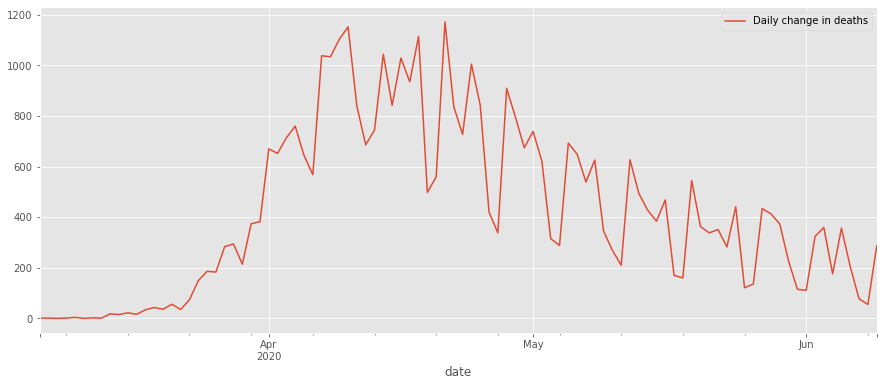

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline
series.plot(figsize=(15, 6))
plt.show()


In [59]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

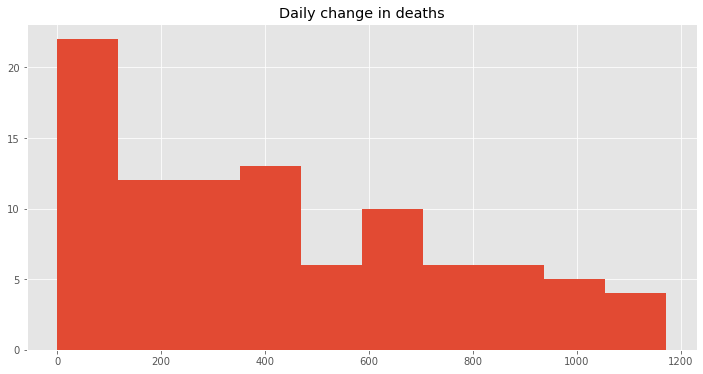

In [60]:
series.hist(figsize = (12,6))
plt.show()

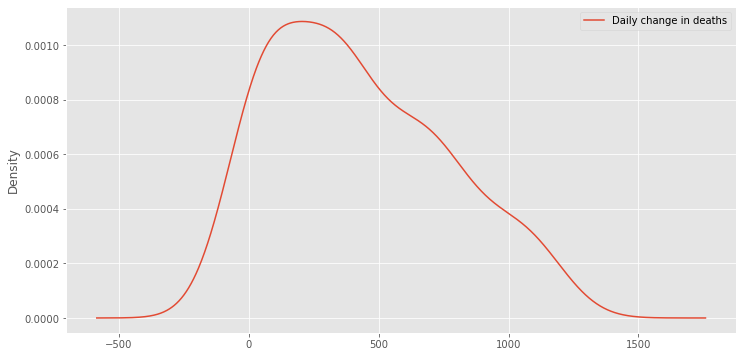

In [61]:
series.plot(kind='kde', figsize = (12,6))
plt.show()


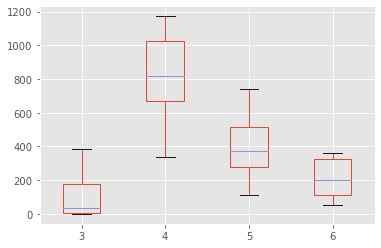

In [62]:
from pandas import DataFrame
from pandas import Grouper
from pandas import concat
groups = series.groupby(Grouper(freq='M'))
months = concat([DataFrame(x[1].values) for x in groups], axis=1)
months = DataFrame(months)
months.columns = range(3,7)
months.boxplot()
plt.show()

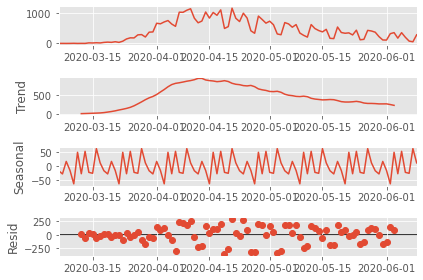

In [63]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(series, freq=12) #every 4 weeks
result.plot();
plt.show()

In [64]:
def stationarity_check(data):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = data.rolling(window=8, center=False).mean()
    roll_std = data.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(data)
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    plt.plot(data, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None


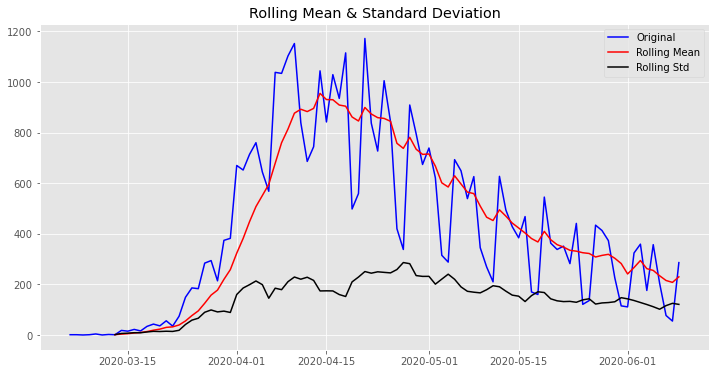

Results of Dickey-Fuller Test: 

Test Statistic                 -3.141817
p-value                         0.023609
#Lags Used                     11.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


In [65]:
stationarity_check(series)


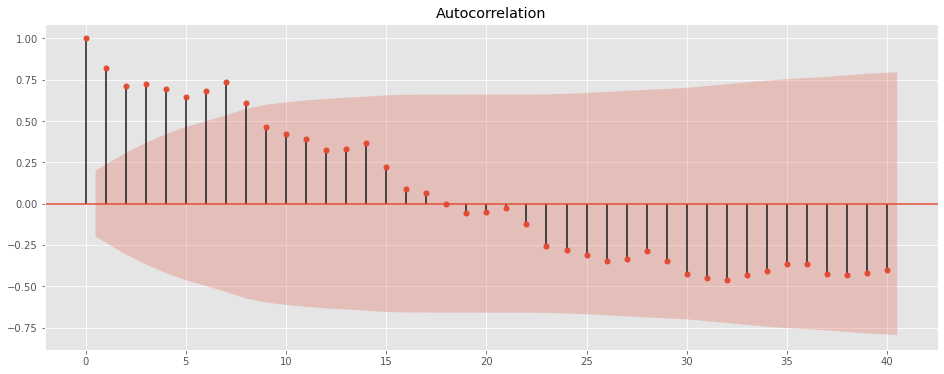

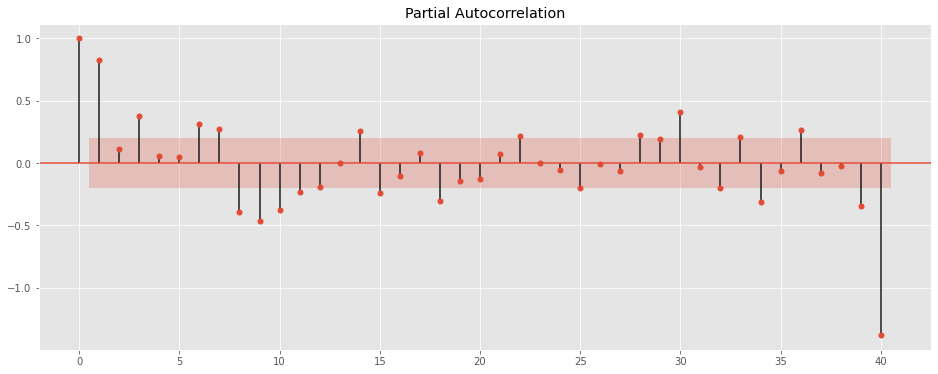

In [66]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(16,6))
plot_acf(series, ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,6))
plot_pacf(series, ax=ax, lags=40);


#### Grid search 

In [67]:
# Define the p, d and q parameters to take any value between 0 and 2
p = range(0, 3)
d = range(0, 3)
q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]


In [68]:
# Gridsearch with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(series,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}7 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 7)7 : AIC Calculated =1468.1184280818652
ARIMA (0, 0, 0) x (0, 0, 1, 7)7 : AIC Calculated =1288.355525483391
ARIMA (0, 0, 0) x (0, 0, 2, 7)7 : AIC Calculated =1142.250359530963
ARIMA (0, 0, 0) x (0, 1, 0, 7)7 : AIC Calculated =1194.7995451907705
ARIMA (0, 0, 0) x (0, 1, 1, 7)7 : AIC Calculated =1101.4259299891626
ARIMA (0, 0, 0) x (0, 1, 2, 7)7 : AIC Calculated =1009.3486197404903
ARIMA (0, 0, 0) x (0, 2, 0, 7)7 : AIC Calculated =1130.1846372316766
ARIMA (0, 0, 0) x (0, 2, 1, 7)7 : AIC Calculated =1023.9294861575498
ARIMA (0, 0, 0) x (0, 2, 2, 7)7 : AIC Calculated =925.7281991527052
ARIMA (0, 0, 0) x (1, 0, 0, 7)7 : AIC Calculated =1206.7532629363754
ARIMA (0, 0, 0) x (1, 0, 1, 7)7 : AIC Calculated =1187.5369658265922
ARIMA (0, 0, 0) x (1, 0, 2, 7)7 : AIC Calculated =1097.2148767541044
ARIMA (0, 0, 0) x (1, 1, 0, 7)7 : AIC Calculated =1112.03039913459
ARIMA (0, 0, 0) x (1, 1, 1, 7)7 : AIC Calculated =1101.4021461467435
ARIMA (0, 0, 0) x (1, 1, 2, 7)7 : AIC C

ARIMA (0, 1, 1) x (1, 1, 1, 7)7 : AIC Calculated =1019.7155341833459
ARIMA (0, 1, 1) x (1, 1, 2, 7)7 : AIC Calculated =935.0812127010572
ARIMA (0, 1, 1) x (1, 2, 0, 7)7 : AIC Calculated =1003.3834687026514
ARIMA (0, 1, 1) x (1, 2, 1, 7)7 : AIC Calculated =954.278955473668
ARIMA (0, 1, 1) x (1, 2, 2, 7)7 : AIC Calculated =867.0926088781986
ARIMA (0, 1, 1) x (2, 0, 0, 7)7 : AIC Calculated =1041.8371427933648
ARIMA (0, 1, 1) x (2, 0, 1, 7)7 : AIC Calculated =1043.6736168303757
ARIMA (0, 1, 1) x (2, 0, 2, 7)7 : AIC Calculated =1021.917087809863
ARIMA (0, 1, 1) x (2, 1, 0, 7)7 : AIC Calculated =962.8197516703132
ARIMA (0, 1, 1) x (2, 1, 1, 7)7 : AIC Calculated =959.4648302254045
ARIMA (0, 1, 1) x (2, 1, 2, 7)7 : AIC Calculated =934.2627409384216
ARIMA (0, 1, 1) x (2, 2, 0, 7)7 : AIC Calculated =907.6280267197054
ARIMA (0, 1, 1) x (2, 2, 1, 7)7 : AIC Calculated =892.7927117801571
ARIMA (0, 1, 1) x (2, 2, 2, 7)7 : AIC Calculated =869.0642341447141
ARIMA (0, 1, 2) x (0, 0, 0, 7)7 : AIC Calcula

ARIMA (0, 2, 2) x (2, 2, 1, 7)7 : AIC Calculated =879.7195214191081
ARIMA (0, 2, 2) x (2, 2, 2, 7)7 : AIC Calculated =837.8970507897391
ARIMA (1, 0, 0) x (0, 0, 0, 7)7 : AIC Calculated =1271.5158320641724
ARIMA (1, 0, 0) x (0, 0, 1, 7)7 : AIC Calculated =1169.8175932179456
ARIMA (1, 0, 0) x (0, 0, 2, 7)7 : AIC Calculated =1073.580556049831
ARIMA (1, 0, 0) x (0, 1, 0, 7)7 : AIC Calculated =1158.2584850885858
ARIMA (1, 0, 0) x (0, 1, 1, 7)7 : AIC Calculated =1062.6023300673764
ARIMA (1, 0, 0) x (0, 1, 2, 7)7 : AIC Calculated =977.3046998767383
ARIMA (1, 0, 0) x (0, 2, 0, 7)7 : AIC Calculated =1131.0780253706498
ARIMA (1, 0, 0) x (0, 2, 1, 7)7 : AIC Calculated =1000.6694952315391
ARIMA (1, 0, 0) x (0, 2, 2, 7)7 : AIC Calculated =905.2264326329387
ARIMA (1, 0, 0) x (1, 0, 0, 7)7 : AIC Calculated =1150.363891527259
ARIMA (1, 0, 0) x (1, 0, 1, 7)7 : AIC Calculated =1145.6088991559654
ARIMA (1, 0, 0) x (1, 0, 2, 7)7 : AIC Calculated =1062.385979800152
ARIMA (1, 0, 0) x (1, 1, 0, 7)7 : AIC Cal

ARIMA (1, 1, 1) x (1, 0, 1, 7)7 : AIC Calculated =1102.8204330991707
ARIMA (1, 1, 1) x (1, 0, 2, 7)7 : AIC Calculated =1021.8936535466438
ARIMA (1, 1, 1) x (1, 1, 0, 7)7 : AIC Calculated =1036.5265528218597
ARIMA (1, 1, 1) x (1, 1, 1, 7)7 : AIC Calculated =1021.1614342196576
ARIMA (1, 1, 1) x (1, 1, 2, 7)7 : AIC Calculated =936.5501771099425
ARIMA (1, 1, 1) x (1, 2, 0, 7)7 : AIC Calculated =992.5714655835097
ARIMA (1, 1, 1) x (1, 2, 1, 7)7 : AIC Calculated =955.9986701445803
ARIMA (1, 1, 1) x (1, 2, 2, 7)7 : AIC Calculated =869.3597882874426
ARIMA (1, 1, 1) x (2, 0, 0, 7)7 : AIC Calculated =1031.8314688650862
ARIMA (1, 1, 1) x (2, 0, 1, 7)7 : AIC Calculated =1033.7121491619848
ARIMA (1, 1, 1) x (2, 0, 2, 7)7 : AIC Calculated =1023.3623630807174
ARIMA (1, 1, 1) x (2, 1, 0, 7)7 : AIC Calculated =952.4541709041349
ARIMA (1, 1, 1) x (2, 1, 1, 7)7 : AIC Calculated =948.8091750196163
ARIMA (1, 1, 1) x (2, 1, 2, 7)7 : AIC Calculated =936.1644802882447
ARIMA (1, 1, 1) x (2, 2, 0, 7)7 : AIC Cal

ARIMA (1, 2, 2) x (2, 1, 1, 7)7 : AIC Calculated =935.1446676225248
ARIMA (1, 2, 2) x (2, 1, 2, 7)7 : AIC Calculated =912.3786628603618
ARIMA (1, 2, 2) x (2, 2, 0, 7)7 : AIC Calculated =882.3160833663196
ARIMA (1, 2, 2) x (2, 2, 1, 7)7 : AIC Calculated =867.5183699436642
ARIMA (1, 2, 2) x (2, 2, 2, 7)7 : AIC Calculated =839.6232378952743
ARIMA (2, 0, 0) x (0, 0, 0, 7)7 : AIC Calculated =1257.975342154287
ARIMA (2, 0, 0) x (0, 0, 1, 7)7 : AIC Calculated =1164.1153651902132
ARIMA (2, 0, 0) x (0, 0, 2, 7)7 : AIC Calculated =1069.0144870436832
ARIMA (2, 0, 0) x (0, 1, 0, 7)7 : AIC Calculated =1138.1042053974795
ARIMA (2, 0, 0) x (0, 1, 1, 7)7 : AIC Calculated =1055.1636679384226
ARIMA (2, 0, 0) x (0, 1, 2, 7)7 : AIC Calculated =970.2768889965425
ARIMA (2, 0, 0) x (0, 2, 0, 7)7 : AIC Calculated =1118.566844535074
ARIMA (2, 0, 0) x (0, 2, 1, 7)7 : AIC Calculated =994.2295585628804
ARIMA (2, 0, 0) x (0, 2, 2, 7)7 : AIC Calculated =899.4092434971803
ARIMA (2, 0, 0) x (1, 0, 0, 7)7 : AIC Calcul

ARIMA (2, 1, 1) x (0, 2, 1, 7)7 : AIC Calculated =957.0602632251687
ARIMA (2, 1, 1) x (0, 2, 2, 7)7 : AIC Calculated =864.5911181533772
ARIMA (2, 1, 1) x (1, 0, 0, 7)7 : AIC Calculated =1100.6127546714074
ARIMA (2, 1, 1) x (1, 0, 1, 7)7 : AIC Calculated =1099.7115251455155
ARIMA (2, 1, 1) x (1, 0, 2, 7)7 : AIC Calculated =1019.1812506793955
ARIMA (2, 1, 1) x (1, 1, 0, 7)7 : AIC Calculated =1021.7194148783954
ARIMA (2, 1, 1) x (1, 1, 1, 7)7 : AIC Calculated =1017.5267986587015
ARIMA (2, 1, 1) x (1, 1, 2, 7)7 : AIC Calculated =933.4170892160101
ARIMA (2, 1, 1) x (1, 2, 0, 7)7 : AIC Calculated =977.6996199200287
ARIMA (2, 1, 1) x (1, 2, 1, 7)7 : AIC Calculated =953.2855554063786
ARIMA (2, 1, 1) x (1, 2, 2, 7)7 : AIC Calculated =866.4838788684326
ARIMA (2, 1, 1) x (2, 0, 0, 7)7 : AIC Calculated =1017.3709157317954
ARIMA (2, 1, 1) x (2, 0, 1, 7)7 : AIC Calculated =1019.189928960965
ARIMA (2, 1, 1) x (2, 0, 2, 7)7 : AIC Calculated =1021.1377406393054
ARIMA (2, 1, 1) x (2, 1, 0, 7)7 : AIC Cal

ARIMA (2, 2, 2) x (2, 0, 1, 7)7 : AIC Calculated =1009.186089438708
ARIMA (2, 2, 2) x (2, 0, 2, 7)7 : AIC Calculated =998.800338870927
ARIMA (2, 2, 2) x (2, 1, 0, 7)7 : AIC Calculated =926.5137057043781
ARIMA (2, 2, 2) x (2, 1, 1, 7)7 : AIC Calculated =919.6077294997219
ARIMA (2, 2, 2) x (2, 1, 2, 7)7 : AIC Calculated =909.1706059827706
ARIMA (2, 2, 2) x (2, 2, 0, 7)7 : AIC Calculated =869.3956997928842
ARIMA (2, 2, 2) x (2, 2, 1, 7)7 : AIC Calculated =851.7038106710813
ARIMA (2, 2, 2) x (2, 2, 2, 7)7 : AIC Calculated =844.7612574829309


In [69]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]


pdq        (2, 2, 2)
pdqs    (0, 2, 2, 7)
aic          836.671
Name: 710, dtype: object

#### Fitting the model 

In [70]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(series, 
                                        order=(2, 2, 2), 
                                        seasonal_order=(0, 2, 2, 7),
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0978      0.231     -0.424      0.672      -0.550       0.354
ar.L2         -0.2923      0.161     -1.818      0.069      -0.607       0.023
ma.L1         -1.5441      0.152    -10.131      0.000      -1.843      -1.245
ma.L2          0.6872      0.152      4.529      0.000       0.390       0.985
ma.S.L7       -1.3397      0.130    -10.328      0.000      -1.594      -1.085
ma.S.L14       0.4550      0.191      2.381      0.017       0.080       0.829
sigma2      2.584e+04   3872.367      6.673      0.000    1.83e+04    3.34e+04


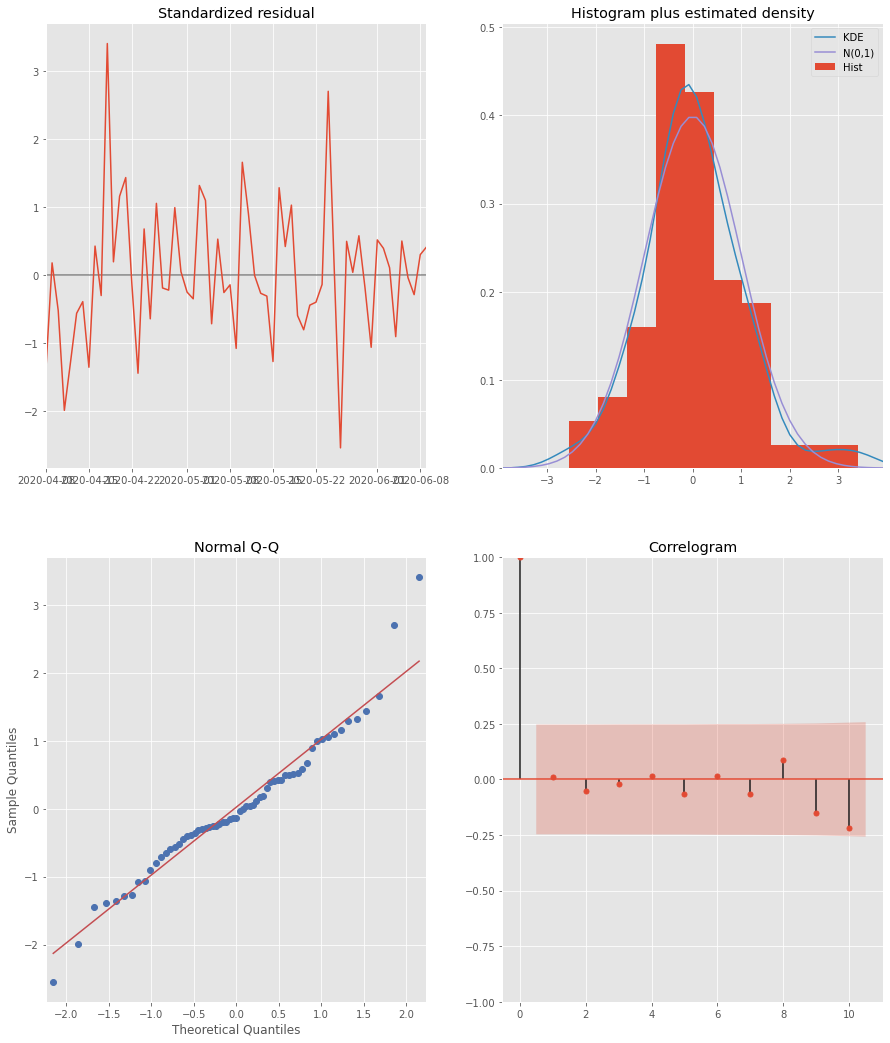

In [71]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

#### Forecasting

In [72]:
pred = output.get_prediction(start=pd.to_datetime('2020-05-15'), dynamic=False)
pred_conf = pred.conf_int()


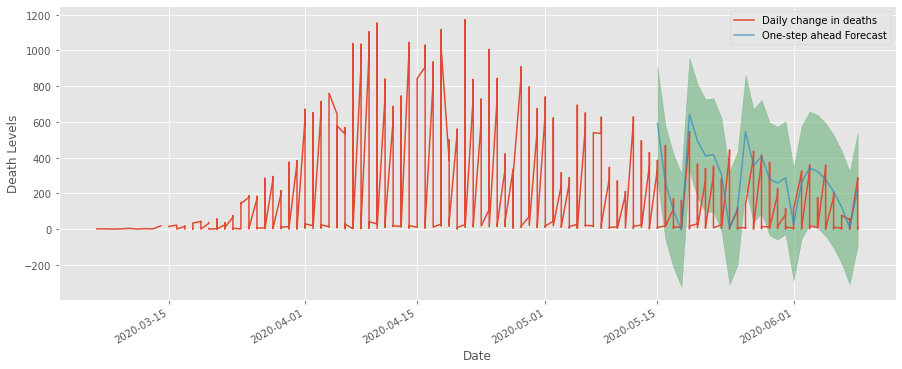

In [73]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = df_d.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.7)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Death Levels')
plt.legend()

plt.show()


In [74]:
# Get the real and predicted values
death_forecasted = pred.predicted_mean
death_truth = df_d['2020-05-15':]['Daily change in deaths']


In [75]:
# Compute the mean square error
mse = ((death_forecasted - death_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))


The Mean Squared Error is 71002.27


In [76]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2020-05-15'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()


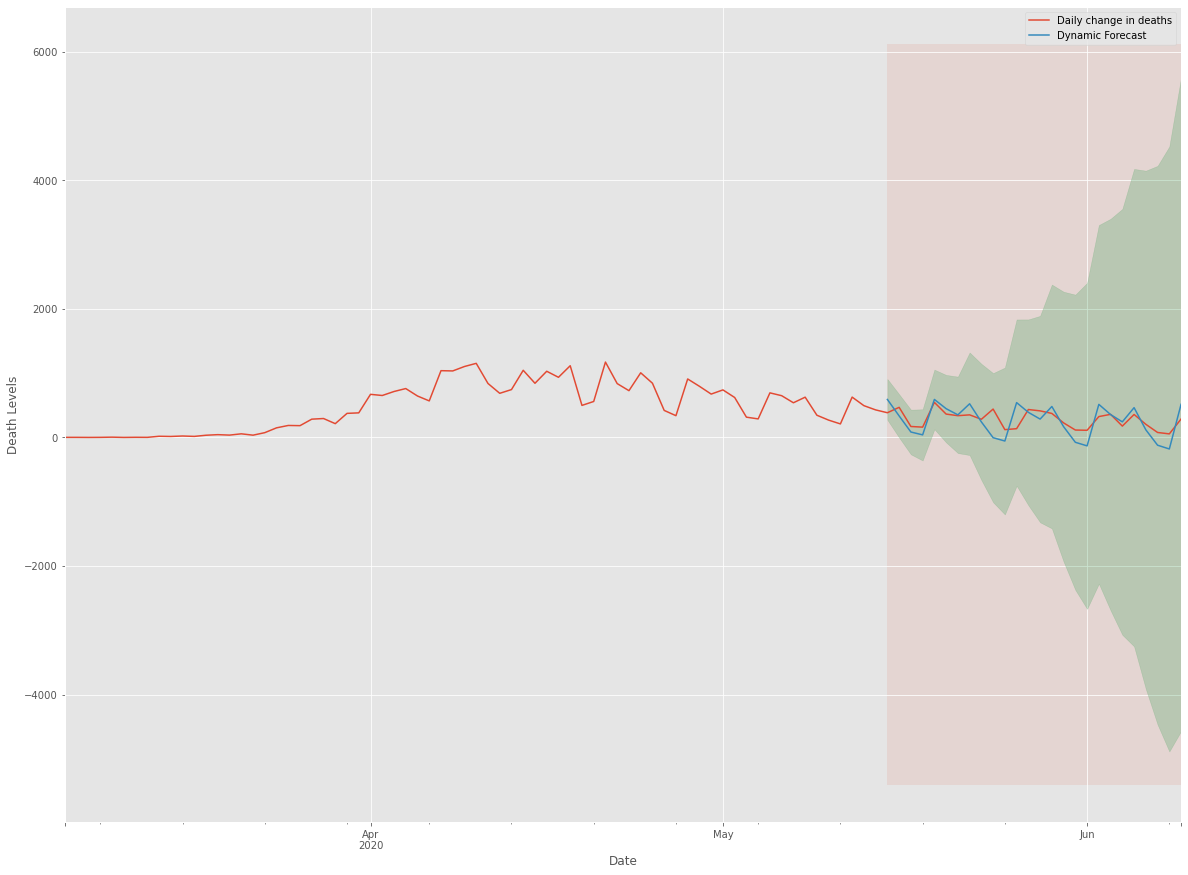

In [77]:
ax = series.plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-05-15'), death_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Death Levels')

plt.legend()
plt.show()


In [78]:
# Extract the predicted and true values of our time series
death_forecasted = pred_dynamic.predicted_mean
death_truth = series['2020-05-15':]['Daily change in deaths']

# Compute the mean square error
mse = ((death_forecasted - death_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 32736.54


In [79]:
# Get forecast 7 steps ahead in future
prediction = output.get_forecast(steps=7)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()


In [80]:
test = pd.read_csv('test.csv')

In [81]:
test['date'] = pd.to_datetime(test['Reporting date'])


In [82]:
test= test[['date', 'Area name', 'Daily change in deaths']].set_index('date')


In [83]:
test= test.loc[test['Area name']=='United Kingdom']


In [84]:
test.drop(['Area name'], axis=1, inplace=True)


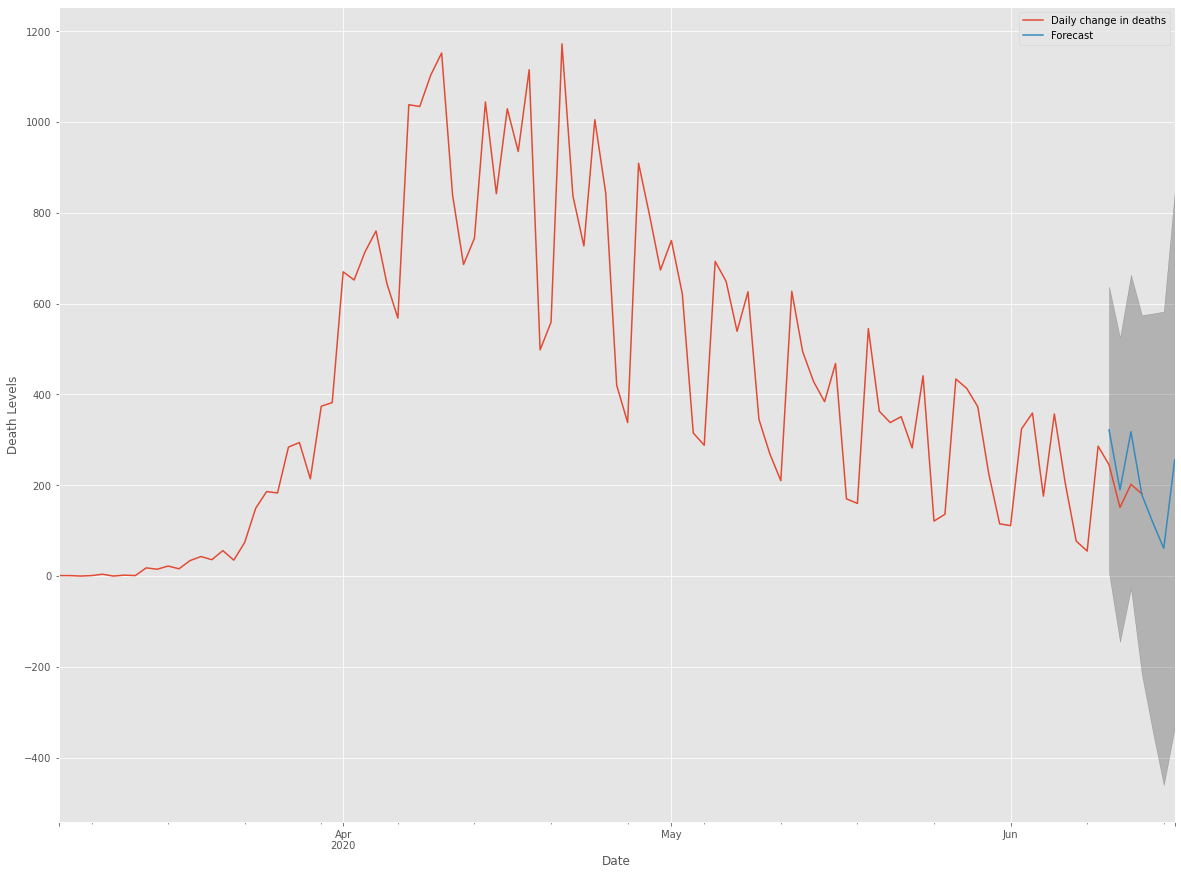

In [85]:
# Plot future predictions with confidence intervals
ax = test.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Death Levels')

plt.legend()
plt.show()


### Sentiment Classifier Modeling 

#### Comparing  VADER Sentiment Analysis with Pre-trained Sentiment Classifier Model

In [86]:
import pandas as pd
from helper_functions import preprocess, remove_emojis

df = pd.read_csv('data/tweets/tweets_labeled.csv', encoding='utf-8', )
df = df[['id', 'label', 'text', 'created_at']]
df = df[df['label'].notnull()]
print(df.shape)
df['text'] = df['text'].replace(r'\n',' ',regex=True)
df['text'] = df['text'].apply(preprocess)
df['text'] = df['text'].str.lower()

# df['label'] = df['label'].astype(int).astype(str)

# df['label'] = df['label'].map({'-1': 'neg', '0': 'neu', '1': 'pos'})

X = df[['text', 'id']]
y = df[['label']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                stratify=y, 
                                                test_size=0.20)

df_validation = pd.concat([X_test, y_test], axis=1)[['id', 'label', 'text']].reset_index(drop=True)
df_train = pd.concat([X_train, y_train], axis=1)[['id', 'label', 'text']].reset_index(drop=True)

print(df_train.label.value_counts(normalize=True))
print(df_validation.label.value_counts(normalize=True))

(1358, 4)
-1.0    0.480663
 0.0    0.281768
 1.0    0.237569
Name: label, dtype: float64
-1.0    0.481618
 0.0    0.279412
 1.0    0.238971
Name: label, dtype: float64


In [87]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Creating columns for each polarity score
df_validation['compound'] = df_validation['text'].apply(lambda cleaned_text: analyzer.polarity_scores(cleaned_text)['compound'])
df_validation['vader_score'] = df_validation['compound'].apply(lambda x: -1 if x<= -0.06 else(1 if x>= 0.06 else 0))

from sklearn.metrics import classification_report
print(classification_report(df_validation['label'], df_validation['vader_score'], ))


              precision    recall  f1-score   support

        -1.0       0.84      0.50      0.63       131
         0.0       0.43      0.38      0.40        76
         1.0       0.40      0.77      0.53        65

    accuracy                           0.53       272
   macro avg       0.55      0.55      0.52       272
weighted avg       0.62      0.53      0.54       272



In [88]:
# Creating columns for each polarity score
df_train['compound'] = df_train['text'].apply(lambda cleaned_text: analyzer.polarity_scores(cleaned_text)['compound'])
df_train['vader_score'] = df_train['compound'].apply(lambda x: -1 if x<= -0.06 else(1 if x>= 0.06 else 0))

from sklearn.metrics import classification_report
print(classification_report(df_train['label'], df_train['vader_score'], ))


              precision    recall  f1-score   support

        -1.0       0.74      0.50      0.60       522
         0.0       0.42      0.42      0.42       306
         1.0       0.43      0.72      0.54       258

    accuracy                           0.53      1086
   macro avg       0.53      0.55      0.52      1086
weighted avg       0.58      0.53      0.53      1086



In [89]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df_validation['label'], df_validation['vader_score'])


array([[66, 29, 36],
       [ 8, 29, 39],
       [ 5, 10, 50]])

In [90]:
confusion_matrix(df_train['label'], df_train['vader_score'])

array([[260, 139, 123],
       [ 57, 129, 120],
       [ 33,  40, 185]])

While the pre-trained sentiment classification model bert-base-uncased correctly identified more than 84% of the labels, VADER sentiment analyzer predicted 62% of the test set and 60% of the train set.   

#### Visualizing  Sentiment Scores

In [91]:
data = pd.read_csv('output.csv')
data.head()

,id,text,label_neg,label_neu,label_pos
0,1245501194375700483,rt why is germany able to test for coronavirus...,0.000064,0.000105,0.999830
1,1245075899558625280,why is germany able to test for coronavirus so...,0.000074,0.000110,0.999816
2,1245501189208276996,rt absolutely wrong how uk s coronavirus test ...,0.999126,0.000657,0.000217
3,1245498501011775489,absolutely wrong how uk s coronavirus test str...,0.999575,0.000324,0.000101
4,1245501189136867328,rt us coast guard orders foreign cruise ships ...,0.000847,0.997944,0.001209


In [92]:
tweet_data = pd.read_csv('data/tweets/tweets_extended.csv', encoding='utf-8')
tweet_data.head()

,id,created_at,text
0,1245501194375700483,Wed Apr 01 23:59:59 +0000 2020,RT @reactionlife: Why is Germany able to test ...
1,1245075899558625280,Tue Mar 31 19:50:01 +0000 2020,Why is Germany able to test for coronavirus so...
2,1245501189208276996,Wed Apr 01 23:59:58 +0000 2020,RT @cdhawesi: 'Absolutely wrong': how UK's cor...
3,1245498501011775489,Wed Apr 01 23:49:17 +0000 2020,'Absolutely wrong': how UK's coronavirus test ...
4,1245501189136867328,Wed Apr 01 23:59:58 +0000 2020,RT @Independent: US Coast Guard orders foreign...


In [93]:
# Join the output data with the dates on tweet ids
merged = pd.merge(data, tweet_data, on='id')
merged.head()

,id,text_x,label_neg,label_neu,label_pos,created_at,text_y
0,1245501194375700483,rt why is germany able to test for coronavirus...,0.000064,0.000105,0.999830,Wed Apr 01 23:59:59 +0000 2020,RT @reactionlife: Why is Germany able to test ...
1,1245075899558625280,why is germany able to test for coronavirus so...,0.000074,0.000110,0.999816,Tue Mar 31 19:50:01 +0000 2020,Why is Germany able to test for coronavirus so...
2,1245501189208276996,rt absolutely wrong how uk s coronavirus test ...,0.999126,0.000657,0.000217,Wed Apr 01 23:59:58 +0000 2020,RT @cdhawesi: 'Absolutely wrong': how UK's cor...
3,1245498501011775489,absolutely wrong how uk s coronavirus test str...,0.999575,0.000324,0.000101,Wed Apr 01 23:49:17 +0000 2020,'Absolutely wrong': how UK's coronavirus test ...
4,1245501189136867328,rt us coast guard orders foreign cruise ships ...,0.000847,0.997944,0.001209,Wed Apr 01 23:59:58 +0000 2020,RT @Independent: US Coast Guard orders foreign...


In [94]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39855 entries, 0 to 39854
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          39855 non-null  int64  
 1   text_x      39855 non-null  object 
 2   label_neg   39855 non-null  float64
 3   label_neu   39855 non-null  float64
 4   label_pos   39855 non-null  float64
 5   created_at  39855 non-null  object 
 6   text_y      39855 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 2.4+ MB


In [95]:
merged['date'] = pd.to_datetime(merged['created_at'], errors='coerce')
merged.head()

,id,text_x,label_neg,label_neu,label_pos,created_at,text_y,date
0,1245501194375700483,rt why is germany able to test for coronavirus...,0.000064,0.000105,0.999830,Wed Apr 01 23:59:59 +0000 2020,RT @reactionlife: Why is Germany able to test ...,2020-04-01 23:59:59+00:00
1,1245075899558625280,why is germany able to test for coronavirus so...,0.000074,0.000110,0.999816,Tue Mar 31 19:50:01 +0000 2020,Why is Germany able to test for coronavirus so...,2020-03-31 19:50:01+00:00
2,1245501189208276996,rt absolutely wrong how uk s coronavirus test ...,0.999126,0.000657,0.000217,Wed Apr 01 23:59:58 +0000 2020,RT @cdhawesi: 'Absolutely wrong': how UK's cor...,2020-04-01 23:59:58+00:00
3,1245498501011775489,absolutely wrong how uk s coronavirus test str...,0.999575,0.000324,0.000101,Wed Apr 01 23:49:17 +0000 2020,'Absolutely wrong': how UK's coronavirus test ...,2020-04-01 23:49:17+00:00
4,1245501189136867328,rt us coast guard orders foreign cruise ships ...,0.000847,0.997944,0.001209,Wed Apr 01 23:59:58 +0000 2020,RT @Independent: US Coast Guard orders foreign...,2020-04-01 23:59:58+00:00


In [96]:
merged = merged.set_index('date')
merged.head()

,id,text_x,label_neg,label_neu,label_pos,created_at,text_y
date,,,,,,,
2020-04-01 23:59:59+00:00,1245501194375700483,rt why is germany able to test for coronavirus...,0.000064,0.000105,0.999830,Wed Apr 01 23:59:59 +0000 2020,RT @reactionlife: Why is Germany able to test ...
2020-03-31 19:50:01+00:00,1245075899558625280,why is germany able to test for coronavirus so...,0.000074,0.000110,0.999816,Tue Mar 31 19:50:01 +0000 2020,Why is Germany able to test for coronavirus so...
2020-04-01 23:59:58+00:00,1245501189208276996,rt absolutely wrong how uk s coronavirus test ...,0.999126,0.000657,0.000217,Wed Apr 01 23:59:58 +0000 2020,RT @cdhawesi: 'Absolutely wrong': how UK's cor...
2020-04-01 23:49:17+00:00,1245498501011775489,absolutely wrong how uk s coronavirus test str...,0.999575,0.000324,0.000101,Wed Apr 01 23:49:17 +0000 2020,'Absolutely wrong': how UK's coronavirus test ...
2020-04-01 23:59:58+00:00,1245501189136867328,rt us coast guard orders foreign cruise ships ...,0.000847,0.997944,0.001209,Wed Apr 01 23:59:58 +0000 2020,RT @Independent: US Coast Guard orders foreign...


In [97]:
merged.index.min()

Timestamp('2013-07-05 10:24:06+0000', tz='UTC')

In [98]:
merged = merged['2020-03-15':'2020-05-30'].drop(['id'], axis=1)

In [99]:
ts = merged.resample('D').mean()
ts.head(10)

,label_neg,label_neu,label_pos
date,,,
2020-03-15 00:00:00+00:00,0.756758,0.167395,0.075846
2020-03-16 00:00:00+00:00,0.478137,0.252480,0.269382
2020-03-17 00:00:00+00:00,0.377328,0.260097,0.362575
2020-03-18 00:00:00+00:00,0.258021,0.303109,0.438869
2020-03-19 00:00:00+00:00,0.445768,0.288185,0.266047
2020-03-20 00:00:00+00:00,0.476571,0.242239,0.281190
2020-03-21 00:00:00+00:00,0.573051,0.224323,0.202626
2020-03-22 00:00:00+00:00,0.439758,0.275429,0.284813
2020-03-23 00:00:00+00:00,0.369690,0.319227,0.311084


In [100]:
from datetime import datetime

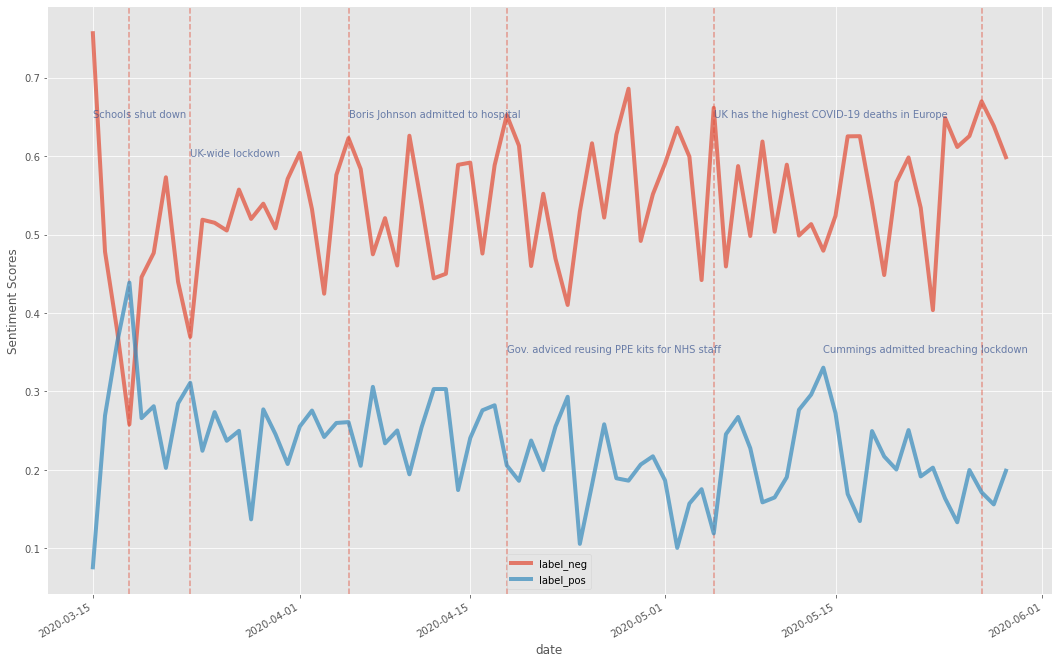

In [101]:
# Visualizing sentiment scores

ts_visual = ts[['label_neg', 'label_pos']]

fig, ax = plt.subplots(figsize=(18, 12))
style = dict(size=9, color='black')


x_line_annotation = datetime(2020, 3, 18) 
x_text_annotation = datetime(2020, 3, 15) 
ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
ax.text(x=x_text_annotation, y=0.65, s='Schools shut down', alpha=0.7, color='#334f8d')

x_line_annotation = datetime(2020, 4, 5) 
x_text_annotation = datetime(2020, 4, 5) 
ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
ax.text(x=x_text_annotation, y=0.65, s='Boris Johnson admitted to hospital', alpha=0.7, color='#334f8d')

x_line_annotation = datetime(2020, 3, 23) 
x_text_annotation = datetime(2020, 3, 23) 
ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
ax.text(x=x_text_annotation, y=0.60, s='UK-wide lockdown', alpha=0.7, color='#334f8d')


x_line_annotation = datetime(2020, 4, 18) 
x_text_annotation = datetime(2020, 4, 18) 
ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
ax.text(x=x_text_annotation, y=0.35, s='Gov. adviced reusing PPE kits for NHS staff', alpha=0.7, color='#334f8d')

x_line_annotation = datetime(2020, 5, 5) 
x_text_annotation = datetime(2020, 5, 5) 
ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
ax.text(x=x_text_annotation, y=0.65, s='UK has the highest COVID-19 deaths in Europe', alpha=0.7, color='#334f8d')

x_line_annotation = datetime(2020, 5, 27) 
x_text_annotation = datetime(2020, 5, 14) 
ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
ax.text(x=x_text_annotation, y=0.35, s='Cummings admitted breaching lockdown', alpha=0.7, color='#334f8d')

ax.set_ylabel('Sentiment Scores')
ts_visual.plot(ax=ax, lw=4, alpha=0.7, subplots=False, legend=True);
plt.show()



### Machine Learning and Regression Models

#### Preprocessing and Feature Engineering

In [102]:
ts["change_neg"] = ts["label_neg"] - ts["label_neg"].shift()
ts["change_pos"] = ts["label_pos"] - ts["label_pos"].shift()
ts["change_neu"] = ts["label_neu"] - ts["label_neu"].shift()

In [103]:
ts.head()

,label_neg,label_neu,label_pos,change_neg,change_pos,change_neu
date,,,,,,
2020-03-15 00:00:00+00:00,0.756758,0.167395,0.075846,NaN,NaN,NaN
2020-03-16 00:00:00+00:00,0.478137,0.252480,0.269382,-0.278621,0.193536,0.085085
2020-03-17 00:00:00+00:00,0.377328,0.260097,0.362575,-0.100810,0.093193,0.007617
2020-03-18 00:00:00+00:00,0.258021,0.303109,0.438869,-0.119306,0.076294,0.043013
2020-03-19 00:00:00+00:00,0.445768,0.288185,0.266047,0.187747,-0.172822,-0.014925


In [104]:
ts.dropna()

,label_neg,label_neu,label_pos,change_neg,change_pos,change_neu
date,,,,,,
2020-03-16 00:00:00+00:00,0.478137,0.252480,0.269382,-0.278621,0.193536,0.085085
2020-03-17 00:00:00+00:00,0.377328,0.260097,0.362575,-0.100810,0.093193,0.007617
2020-03-18 00:00:00+00:00,0.258021,0.303109,0.438869,-0.119306,0.076294,0.043013
2020-03-19 00:00:00+00:00,0.445768,0.288185,0.266047,0.187747,-0.172822,-0.014925
2020-03-20 00:00:00+00:00,0.476571,0.242239,0.281190,0.030802,0.015143,-0.045945
...,...,...,...,...,...,...
2020-05-25 00:00:00+00:00,0.611680,0.255064,0.133256,-0.036997,-0.030459,0.067456
2020-05-26 00:00:00+00:00,0.625655,0.174457,0.199888,0.013975,0.066632,-0.080606
2020-05-27 00:00:00+00:00,0.669911,0.158592,0.171497,0.044257,-0.028391,-0.015866


In [105]:
from datetime import datetime
d = datetime.now()
only_date, only_time = d.date(), d.time()

In [106]:
ts = ts['2020-03-16':'2020-05-29']

In [107]:
ts.index = [d.date() for d in ts.index]

In [108]:
series.head()

,Daily change in deaths
date,
2020-03-06,1.0
2020-03-07,1.0
2020-03-08,0.0
2020-03-09,1.0
2020-03-10,4.0


In [109]:
series = series['2020-03-16':'2020-05-29']
len(ts)

75

In [110]:
df_final = pd.merge(ts, series, how='inner', left_index=True, right_index=True)

In [111]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 75 entries, 2020-03-16 to 2020-05-29
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   label_neg               75 non-null     float64
 1   label_neu               75 non-null     float64
 2   label_pos               75 non-null     float64
 3   change_neg              75 non-null     float64
 4   change_pos              75 non-null     float64
 5   change_neu              75 non-null     float64
 6   Daily change in deaths  75 non-null     float64
dtypes: float64(7)
memory usage: 7.2 KB


In [112]:
df_final.rename({'Daily change in deaths': 'change_deaths'}, axis=1, inplace=True)

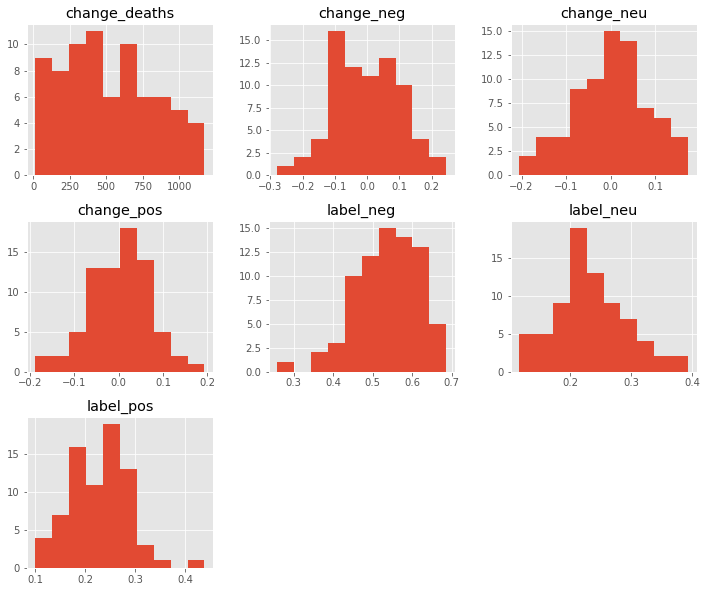

In [113]:
df_final.hist(figsize=(12,10));

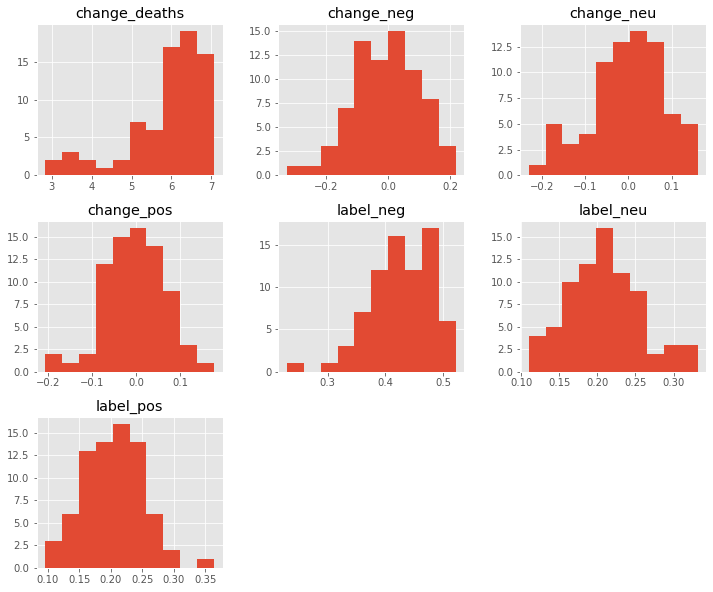

In [114]:
import numpy as np
df_log = (np.log1p(df_final)).replace(-np.inf, 0)
df_log.hist(figsize=(12,10))
plt.show()

#### Linear Regression

In [115]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.tools.tools import add_constant
import scipy.stats as stats

In [116]:
n = -2
m = merged.copy()
m = m[['label_neg', 'label_neu', 'label_pos']]
m = m.idxmax(axis=1).to_frame(name='label')
m['label'] = m['label'].str.replace('label_', '')
m = pd.get_dummies(m)
m = m.resample('D').sum()
m['sum'] = m.sum(axis=1)
m['ratio_neg'] = m['label_neg'] / m['sum']
m['ratio_pos'] = m['label_pos'] / m['sum']
m['shifted_ratio_neg'] = m['ratio_neg'].shift(n)
m['shifted_ratio_pos'] = m['ratio_pos'].shift(n)
m['day_of_week'] = m.index.weekday.astype('category')


m = m['2020-03-16':'2020-05-29']
m.index = [d.date() for d in m.index]
m = pd.merge(m, series, how='inner', left_index=True, right_index=True)
m.rename({'Daily change in deaths': 'deaths'}, axis=1, inplace=True)
m["shifted_deaths"] = m["deaths"].shift(n)
m.dropna(inplace=True)

m = m[['ratio_neg', 'ratio_pos', 'day_of_week', 'deaths', 'shifted_deaths', 'shifted_ratio_neg', 'shifted_ratio_pos']]

m = pd.get_dummies(m, drop_first=True)
m.head(10)


,ratio_neg,ratio_pos,deaths,shifted_deaths,shifted_ratio_neg,shifted_ratio_pos,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
date,,,,,,,,,,,,
2020-03-16,0.486979,0.265625,22.0,34.0,0.253133,0.426065,0,0,0,0,0,0
2020-03-17,0.372222,0.361111,16.0,43.0,0.456091,0.260623,1,0,0,0,0,0
2020-03-18,0.253133,0.426065,34.0,36.0,0.473973,0.284932,0,1,0,0,0,0
2020-03-19,0.456091,0.260623,43.0,56.0,0.571053,0.192105,0,0,1,0,0,0
2020-03-20,0.473973,0.284932,36.0,35.0,0.446377,0.281159,0,0,0,1,0,0
2020-03-21,0.571053,0.192105,56.0,74.0,0.374302,0.310056,0,0,0,0,1,0
2020-03-22,0.446377,0.281159,35.0,149.0,0.521505,0.223118,0,0,0,0,0,1
2020-03-23,0.374302,0.310056,74.0,186.0,0.506631,0.278515,0,0,0,0,0,0
2020-03-24,0.521505,0.223118,149.0,183.0,0.513441,0.236559,1,0,0,0,0,0


In [117]:
outcome = 'ratio_neg'
predictors = [ 'ratio_pos', 
              'deaths', 
              'shifted_deaths',
              'shifted_ratio_neg',
              'shifted_ratio_pos',
              'day_of_week_1',
              'day_of_week_2', 
              'day_of_week_3',
              'day_of_week_4',
              'day_of_week_5',
              'day_of_week_6'
]
        
X = sm.add_constant(m)
predictor_sum = '+'.join(predictors)
formula = outcome + '~' + predictor_sum
model = ols(formula=formula, data=m).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ratio_neg   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     4.893
Date:                Mon, 22 Jun 2020   Prob (F-statistic):           2.20e-05
Time:                        22:59:21   Log-Likelihood:                 100.39
No. Observations:                  73   AIC:                            -176.8
Df Residuals:                      61   BIC:                            -149.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.7256      0.105      6.924      0.000       0.516       0.935
ratio_pos            -0.8666      0.141     -6.136      0.000      -1.149      -0.584
deaths             5.146e-05   4.54e-05      1.133      0.262   -3.94e-05       0.000
shifted_deaths    -1.921e-05   4.66e-05     -0.413      0.681      -0.000    7.39e-05
shifted_ratio_neg    -0.0236      0.127     -0.185      0.853      -0.278       0.231
shifted_ratio_pos    -0.0237      0.184     -0.129      0.898      -0.392       0.344
day_of_week_1         0.0106      0.032      0.334      0.740      -0.053       0.074
day_of_week_2         0.0083      0.032      0.262      0.794      -0.055       0.072
day_of_week_3         0.0085      0.035      0.244      0.808      -0.061       0.079
day_of_week_4        -0.0048      0.038     -0.128      0.899      -0.080       0.070
day_of_week_5         0.0066      0.037      0.179      0.859      -0.067       0.080
day_of_week_6         0.0332      0.030      1.110      0.271      -0.027       0.093
==============================================================================
Omnibus:                        2.597   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.273   Jarque-Bera (JB):                2.564
Skew:                          -0.421   Prob(JB):                        0.277
Kurtosis:                       2.632   Cond. No.                     2.44e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Decision Tree Classifier

In [118]:
# binning the target variable
m['ratio_neg_cat'] = m['ratio_neg'].apply(
    lambda x: 0 if 0 < x <= 0.4 
    else(1 if 0.4 < x <= 0.5 
         else (2 if 0.5 < x <= 0.6 else(3))))

In [119]:
# distribution of the target categories
m['ratio_neg_cat'].value_counts(normalize=True)

2    0.424658
1    0.273973
3    0.232877
0    0.068493
Name: ratio_neg_cat, dtype: float64

In [120]:
print(m.shape)
m.columns

(73, 13)


Index(['ratio_neg', 'ratio_pos', 'deaths', 'shifted_deaths',
       'shifted_ratio_neg', 'shifted_ratio_pos', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'ratio_neg_cat'],
      dtype='object')

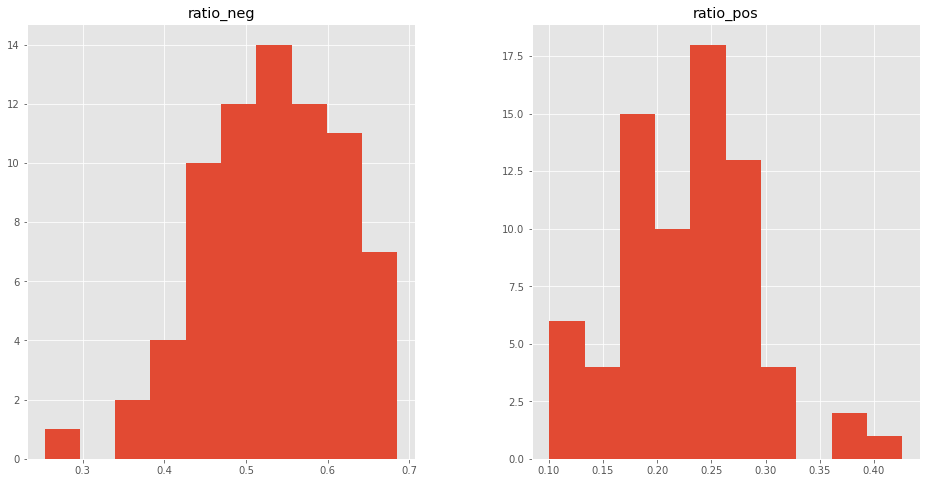

In [121]:
m[['ratio_neg', 'ratio_pos']].hist(figsize=(16,8))
plt.show()

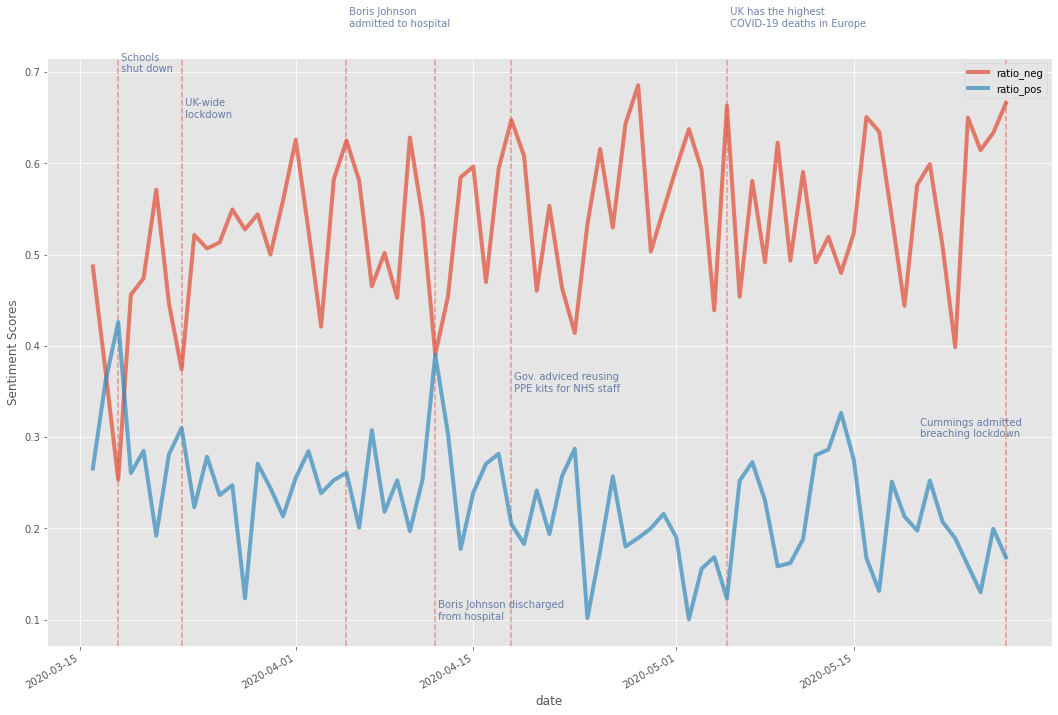

In [122]:
# Visualizing sentiment scores

ts_visual = m[['ratio_neg', 'ratio_pos']]

fig, ax = plt.subplots(figsize=(18, 12))
style = dict(size=9, color='black')


x_line_annotation = datetime(2020, 3, 18) 
x_text_annotation = datetime(2020, 3, 18) 
ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
ax.text(x=x_text_annotation, y=0.7, s=' Schools \n shut down', alpha=0.7, color='#334f8d')

x_line_annotation = datetime(2020, 3, 23) 
x_text_annotation = datetime(2020, 3, 23) 
ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
ax.text(x=x_text_annotation, y=0.65, s=' UK-wide \n lockdown', alpha=0.7, color='#334f8d')

x_line_annotation = datetime(2020, 4, 5) 
x_text_annotation = datetime(2020, 4, 5) 
ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
ax.text(x=x_text_annotation, y=0.75, s=' Boris Johnson \n admitted to hospital', alpha=0.7, color='#334f8d')

x_line_annotation = datetime(2020, 4, 12) 
x_text_annotation = datetime(2020, 4, 12) 
ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
ax.text(x=x_text_annotation, y=0.1, s=' Boris Johnson discharged \n from hospital', alpha=0.7, color='#334f8d')


x_line_annotation = datetime(2020, 4, 18) 
x_text_annotation = datetime(2020, 4, 18) 
ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
ax.text(x=x_text_annotation, y=0.35, s=' Gov. adviced reusing \n PPE kits for NHS staff', alpha=0.7, color='#334f8d')

x_line_annotation = datetime(2020, 5, 5) 
x_text_annotation = datetime(2020, 5, 5) 
ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
ax.text(x=x_text_annotation, y=0.75, s=' UK has the highest \n COVID-19 deaths in Europe', alpha=0.7, color='#334f8d')

x_line_annotation = datetime(2020, 5, 27) 
x_text_annotation = datetime(2020, 5, 20) 
ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
ax.text(x=x_text_annotation, y=0.3, s=' Cummings admitted \n breaching lockdown', alpha=0.7, color='#334f8d')

ax.set_ylabel('Sentiment Scores')
ts_visual.plot(ax=ax, lw=4, alpha=0.7, subplots=False, legend=True);
plt.show()

In [123]:
# Train, test split
y = m['ratio_neg_cat']
X = m.drop(['ratio_neg_cat'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33, test_size=0.20)

In [125]:
# importing libraries
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, recall_score
import xgboost as xgb

In [128]:
# Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=33, )  
dtc.fit(X_train, y_train) 

# Predicted values
y_pred = dtc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         2

    accuracy                           0.93        15
   macro avg       0.94      0.92      0.91        15
weighted avg       0.95      0.93      0.93        15



In [129]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [130]:
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(dtc, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=33),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

In [131]:
# Mean training score
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])

# Mean test score
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 97.56%
Mean Test Score: 93.33%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [132]:
# Decision Tree Classifier
dtc = DecisionTreeClassifier(criterion = 'gini',
                            min_samples_leaf = 1,
                            min_samples_split = 2,
                            random_state = 33, 
                            class_weight = 'balanced')  
dtc.fit(X_train, y_train) 

# Predicted values
y_pred = dtc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         2

    accuracy                           0.93        15
   macro avg       0.94      0.92      0.91        15
weighted avg       0.95      0.93      0.93        15



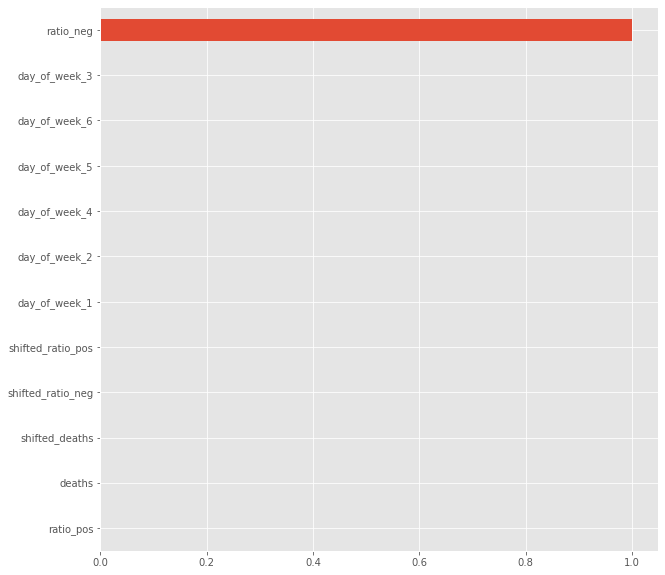

In [133]:
feat_importances = pd.Series(dtc.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=True)
feat_importances.plot(kind='barh',figsize=(10,10))
plt.show();

In [134]:
# RandomForest 
rfc = RandomForestClassifier(random_state=33,class_weight='balanced')

rfc.fit(X_train, y_train) 

# Predicted values
y_pred = rfc.predict(X_test)

# Print accuracy report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.60      1.00      0.75         3
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         2

    accuracy                           0.87        15
   macro avg       0.90      0.83      0.81        15
weighted avg       0.92      0.87      0.85        15



In [135]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6],
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [2,3,4],
    'random_state':[33],
    'class_weight':['balanced']
}

In [136]:
rf_grid_search = GridSearchCV(rfc, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Training Accuracy: 98.25%

Optimal Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 30, 'random_state': 33}


In [ ]:
rfc = RandomForestClassifier(criterion = 'entropy',
                             max_depth = None,
                             min_samples_leaf = 2, 
                             min_samples_split = 2,
                             n_estimators = 30,
                             random_state=33,
                             class_weight='balanced')

rfc.fit(X_train, y_train) 

# Predicted values
y_pred = rfc.predict(X_test)

# Print accuracy report
print(classification_report(y_test, y_pred))

In [ ]:
feat_importances = pd.Series(rfc.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=True)
feat_importances.plot(kind='barh',figsize=(10,10))
plt.show();

In [ ]:
# Naive Bayes Classifier
nbc = GaussianNB()
nbc.fit(X_train, y_train)
# Predicted values
y_pred = nbc.predict(X_test)

# Print accuracy report
print(classification_report(y_test, y_pred))

In [ ]:
import xgboost as xgb

# XGBoost 
xgbc = xgb.XGBClassifier(random_state=123, 
                         class_weight='balanced')   
xgbc.fit(X_train, y_train)
# Predicted values
y_pred = xgbc.predict(X_test)

# Print accuracy report
print(classification_report(y_test, y_pred))

In [ ]:
grid_params = {
    'learning_rate': [0.007, 0.009],
    'max_depth': [3, 4, 5],
    'gamma': [2],
    'min_child_weight': [3, 5, 10],
    'subsample': [0.6, 0.7],
    'colsample_bytree': [0.7, 0.8],
    'n_estimators': [100, 200, 300],
    'grow_policy':['depthwise'],
    'booster': ['dart'],
    'random_state': [33],
    'tree_method': ['hist'],
}

In [ ]:
# Instantiate GridSearchCV
xgb_grid_search = GridSearchCV(xgbc, grid_params, cv=3, return_train_score=True)

# Fit to the data
xgb_grid_search.fit(X_train, y_train)

In [ ]:
# Mean training score
xgb_gs_training_score = np.mean(xgb_grid_search.cv_results_['mean_train_score'])

# Mean test score
xgb_gs_testing_score = xgb_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {xgb_gs_training_score :.2%}")
print(f"Mean Test Score: {xgb_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
xgb_grid_search.best_params_

In [ ]:
feat_importances = pd.Series(xgbc.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=True)
feat_importances.plot(kind='barh',figsize=(10,10))
plt.show();

## Interpretation 